In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
import random
import tqdm
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import math
import logging
from functools import partial
from collections import OrderedDict
from sklearn.metrics import classification_report
from torchsummary import summary

In [2]:
!nvidia-smi
torch.cuda.is_available()

Wed Aug 18 22:54:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 35%   25C    P8    30W / 260W |   2482MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [3]:
###Read the EEG Spectrogram###

dat1 = np.load('/project/hikaku_db/data/sleep_SHHS/stages_sig/C4_spec_30_np/spec_1601_2308_30.npy')
dat2 = np.load('/project/hikaku_db/data/sleep_SHHS/stages_sig/C3_spec_30_np/spec_c3_1601_2308_30.npy')
print(dat1.shape)
print(dat2.shape)

(692382, 32, 30)
(692382, 32, 30)


In [4]:
dat = np.concatenate((dat1.reshape(-1,1,32,30), dat2.reshape(-1,1,32,30)), axis=1)
print(dat.shape)        
fixdata = dat[:,:,0:16,:]  
mean_p1 = np.mean(dat[:,:,16:20,:], axis = 2)
mean_p2 = np.mean(dat[:,:,20:24,:], axis = 2)
mean_p3 = np.mean(dat[:,:,24:28,:], axis = 2)
mean_p4 = np.mean(dat[:,:,28:32,:], axis = 2)
num_data = len(dat)
ch = 2
inputdat = np.concatenate((fixdata,mean_p1.reshape(num_data, ch, 1, 30),mean_p2.reshape(num_data, ch, 1, 30),mean_p3.reshape(num_data, ch, 1, 30),mean_p4.reshape(num_data, ch, 1, 30)),axis=2)
print(inputdat.shape)

(692382, 2, 32, 30)
(692382, 2, 20, 30)


In [5]:
###Read the Lable###
index = pd.read_csv("/project/hikaku_db/data/sleep_SHHS/stages_sig/ann_delrecords_5class.csv", header=None)
index = index[1594504 : 2286886].astype(int)
print(index.apply(pd.value_counts))
label = index.values.tolist()  #list
weight = 1/(index.apply(pd.value_counts)/len(index))
weight = (weight/weight.max()).sort_index()
print(weight)

        0
2  283199
0  208397
4   88394
3   87602
1   24790
          0
0  0.118956
1  1.000000
2  0.087536
3  0.282984
4  0.280449


In [6]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data,label ,transform = None):
        self.transform = transform

        self.data = data
        self.label = label

        self.datanum = len(data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data = torch.tensor(self.data[idx]).float()
        out_label = torch.tensor(self.label[idx])
        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [7]:
train, test, train_label, test_label = train_test_split(inputdat, np.array(label),test_size = 0.1,stratify = label, random_state = 0)
print('train data:',len(train))
print('test data:',len(test))

train_data_set = Mydatasets(data=train,label=train_label)
test_data_set = Mydatasets(data=test,label=test_label)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=False)

train data: 623143
test data: 69239


In [8]:
class LSTM(nn.Module):
    def __init__(self,hidden_size,num_layers):
        super().__init__()
        self.to_patch = nn.Sequential(
            #(batch, 4, 20, 30) -> (batch, 150, 16)  or  (batch, 30, 80)
            Rearrange('b c (h p1) (w p2) -> b (h w p2) (c p1)', p1 = 4, p2 = 30),  
        )
        
        self.lstm = nn.LSTM(
            input_size = 8,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first=True
        )
        
    def forward(self,x):
        # output: [batch_size, time_step, hidden_size] ,same as input: [batch, seq_len, input_size](guide name)
        # LSTM : batch_first = True, but the first dim of h_n and c_n will still be num_layers
        # h_n and c_n: [num_layers,batch_size, hidden_size] 
        x = self.to_patch(x)
        mean_out = True            #use mean_out of LSTM as output 
        output,(h_n,c_n)=self.lstm(x) 
        out = output[:,-1,:]     #output of the last timestep
        if mean_out:
            out = output.mean(dim = 1)      #mean of all timestep output
        return out

##LSTM model

class LSTMModel(nn.Module):
    def __init__(self,hidden_size,num_layers):
        super().__init__()     
        self.lstm = LSTM(hidden_size,num_layers)
    
        self.to_latent = nn.Identity()
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, 5)
        )

    def forward(self, x):
        x = self.lstm(x)        
        x = self.to_latent(x)
        return self.mlp_head(x)

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

LSTMModel = LSTMModel(
    hidden_size = 32,
    num_layers = 8
).to(DEVICE)

#summary(Transmodel,(2286886, 20, 30))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(LSTMModel.parameters(), lr=1e-4)

LSTMModel.load_state_dict(torch.load('/project/hikaku_db/ziwei/Model_11/Model_11_state_2'))

In [ ]:
# pytorch_total_params = sum(p.numel() for p in LSTMModel.parameters())
# pytorch_total_params

In [10]:
EPOCH = 100
loss_list=[]
los_min=10**10
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count=0
    for _, (inputs, labels) in enumerate(train_dataloader, 0):

        optimizer.zero_grad()
        inputs1 = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = LSTMModel(inputs1)
        
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        count=count+1

        # print statistics
        running_loss += loss.item()
    loss_loss=running_loss/count
    loss_list.append(loss_loss)
    print('epoch',epoch+1,':finished')
    print('train_loss:',loss_loss)
    with torch.no_grad():
        count=0
        running_loss=0.0
        pre=list()
        lab=list()
        for _, (inputs, labels) in enumerate(test_dataloader, 0):
            inputs1 = inputs.to(DEVICE)
            labels=labels.to(DEVICE)
            outputs = LSTMModel(inputs1)
            loss =criterion(outputs, labels.squeeze())
            running_loss += loss.item()
            count+=1
            _, predicted = torch.max(F.softmax(outputs).data, 1)
            predicted=predicted.to('cpu')
            labels=labels.to('cpu')
            predicted=predicted.tolist()
            labels=labels.tolist()
            pre.append(predicted)
            lab.append(labels)
        loss_loss=running_loss/count
        val_loss_list.append(loss_loss)
        pre=sum(pre,[])
        lab=sum(lab,[])
        print('val_loss:',loss_loss)
        cl = classification_report(lab, pre,output_dict=True)
        print(cl)
        ac_list.append(cl['accuracy'])
#         if los_min>loss_loss:
#             los_min=loss_loss
#             torch.save(Transmodel.state_dict(),'Trans_8lay_state') 

        torch.save(LSTMModel.state_dict(),'/project/hikaku_db/ziwei/Model_11/Model_11_state_3')

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1 :finished
train_loss: 0.4704728583048976


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  1%|          | 1/100 [06:25<10:35:56, 385.42s/it]

val_loss: 0.474704639721049
{'0': {'precision': 0.8706352732119058, 'recall': 0.9404030710172745, 'f1-score': 0.9041753171856979, 'support': 20840}, '1': {'precision': 0.3989071038251366, 'recall': 0.02944735780556676, 'f1-score': 0.05484598046581518, 'support': 2479}, '2': {'precision': 0.8360782930700053, 'recall': 0.837111581920904, 'f1-score': 0.8365946184384648, 'support': 28320}, '3': {'precision': 0.8636541726524749, 'recall': 0.7549086757990867, 'f1-score': 0.8056283121154899, 'support': 8760}, '4': {'precision': 0.665938864628821, 'recall': 0.793552036199095, 'f1-score': 0.7241664085888304, 'support': 8840}, 'accuracy': 0.8233221161484134, 'macro avg': {'precision': 0.7270427414776688, 'recall': 0.6710845445483853, 'f1-score': 0.6650821273588596, 'support': 69239}, 'weighted avg': {'precision': 0.8125937286733727, 'recall': 0.8233221161484134, 'f1-score': 0.8106742075413997, 'support': 69239}}
epoch 2 :finished
train_loss: 0.45438439103261


  2%|▏         | 2/100 [12:50<10:29:22, 385.33s/it]

val_loss: 0.45750215633078556
{'0': {'precision': 0.9221151975092431, 'recall': 0.9095489443378119, 'f1-score': 0.9157889651174026, 'support': 20840}, '1': {'precision': 0.4012345679012346, 'recall': 0.07866075030254134, 'f1-score': 0.1315345699831366, 'support': 2479}, '2': {'precision': 0.8260248827248623, 'recall': 0.8580508474576272, 'f1-score': 0.8417333471890263, 'support': 28320}, '3': {'precision': 0.7986141186660892, 'recall': 0.8420091324200913, 'f1-score': 0.8197377194932207, 'support': 8760}, '4': {'precision': 0.7013517761710154, 'recall': 0.7571266968325792, 'f1-score': 0.7281727683185553, 'support': 8840}, 'accuracy': 0.8307312352864715, 'macro avg': {'precision': 0.7298681085944889, 'recall': 0.6890792742701302, 'f1-score': 0.6873934740202683, 'support': 69239}, 'weighted avg': {'precision': 0.8203523342271639, 'recall': 0.8307312352864715, 'f1-score': 0.8213139172883018, 'support': 69239}}
epoch 3 :finished
train_loss: 0.44801533587037434


  3%|▎         | 3/100 [19:19<10:24:46, 386.46s/it]

val_loss: 0.4465283820347072
{'0': {'precision': 0.9003915353780181, 'recall': 0.9269193857965451, 'f1-score': 0.9134629025393673, 'support': 20840}, '1': {'precision': 0.36855036855036855, 'recall': 0.12101653892698669, 'f1-score': 0.18220467658669906, 'support': 2479}, '2': {'precision': 0.8349191083021331, 'recall': 0.85829802259887, 'f1-score': 0.8464471645221389, 'support': 28320}, '3': {'precision': 0.8338576255388559, 'recall': 0.8170091324200913, 'f1-score': 0.8253474024101943, 'support': 8760}, '4': {'precision': 0.7215094339622642, 'recall': 0.7570135746606335, 'f1-score': 0.7388352194314105, 'support': 8840}, 'accuracy': 0.834399688037089, 'macro avg': {'precision': 0.731845614346328, 'recall': 0.6960513308806253, 'f1-score': 0.701259473097962, 'support': 69239}, 'weighted avg': {'precision': 0.8233140470540802, 'recall': 0.834399688037089, 'f1-score': 0.8264270507421074, 'support': 69239}}
epoch 4 :finished
train_loss: 0.4435063808838102


  4%|▍         | 4/100 [26:03<10:26:42, 391.69s/it]

val_loss: 0.44524843154850374
{'0': {'precision': 0.9090437570728027, 'recall': 0.9250959692898273, 'f1-score': 0.9169996194824962, 'support': 20840}, '1': {'precision': 0.3976311336717428, 'recall': 0.09479628882613957, 'f1-score': 0.1530944625407166, 'support': 2479}, '2': {'precision': 0.834841472680804, 'recall': 0.8535310734463277, 'f1-score': 0.8440828299053672, 'support': 28320}, '3': {'precision': 0.8190881595160748, 'recall': 0.8347031963470319, 'f1-score': 0.8268219596313676, 'support': 8760}, '4': {'precision': 0.7131499110785647, 'recall': 0.7711538461538462, 'f1-score': 0.7410185336159574, 'support': 8840}, 'accuracy': 0.8350062825864036, 'macro avg': {'precision': 0.7347508868039978, 'recall': 0.6958560748126346, 'f1-score': 0.696403481035181, 'support': 69239}, 'weighted avg': {'precision': 0.8239917889539876, 'recall': 0.8350062825864036, 'f1-score': 0.825947561188196, 'support': 69239}}
epoch 5 :finished
train_loss: 0.44027356239630844


  5%|▌         | 5/100 [32:56<10:30:27, 398.18s/it]

val_loss: 0.44339997828172006
{'0': {'precision': 0.9195153613154479, 'recall': 0.9177063339731286, 'f1-score': 0.9186099570114556, 'support': 20840}, '1': {'precision': 0.3776435045317221, 'recall': 0.050423557886244454, 'f1-score': 0.0889679715302491, 'support': 2479}, '2': {'precision': 0.8340230514039468, 'recall': 0.8610875706214689, 'f1-score': 0.8473392518980525, 'support': 28320}, '3': {'precision': 0.8355332320990538, 'recall': 0.8165525114155251, 'f1-score': 0.8259338375382483, 'support': 8760}, '4': {'precision': 0.6860995246871665, 'recall': 0.8001131221719457, 'f1-score': 0.7387330931119119, 'support': 8840}, 'accuracy': 0.8356850907725415, 'macro avg': {'precision': 0.7305629348074674, 'recall': 0.6891766192136626, 'f1-score': 0.6839168222179834, 'support': 69239}, 'weighted avg': {'precision': 0.8247202025553535, 'recall': 0.8356850907725415, 'f1-score': 0.8250640777486594, 'support': 69239}}
epoch 6 :finished
train_loss: 0.4370835672628222


  6%|▌         | 6/100 [39:45<10:28:33, 401.20s/it]

val_loss: 0.4460162532252437
{'0': {'precision': 0.9282743774157248, 'recall': 0.9104126679462572, 'f1-score': 0.9192567649410113, 'support': 20840}, '1': {'precision': 0.3732590529247911, 'recall': 0.05405405405405406, 'f1-score': 0.09443269908386188, 'support': 2479}, '2': {'precision': 0.8242007608623106, 'recall': 0.8721045197740113, 'f1-score': 0.8474762378615791, 'support': 28320}, '3': {'precision': 0.8310607811416686, 'recall': 0.8210045662100457, 'f1-score': 0.8260020673021706, 'support': 8760}, '4': {'precision': 0.6991141431626108, 'recall': 0.7766968325791855, 'f1-score': 0.7358662451101228, 'support': 8840}, 'accuracy': 0.8356995334999061, 'macro avg': {'precision': 0.7311818231014212, 'recall': 0.6868545281127107, 'f1-score': 0.6846068028597492, 'support': 69239}, 'weighted avg': {'precision': 0.8242778525617557, 'recall': 0.8356995334999061, 'f1-score': 0.8251530555753259, 'support': 69239}}
epoch 7 :finished
train_loss: 0.43493130933189217


  7%|▋         | 7/100 [46:32<10:24:53, 403.15s/it]

val_loss: 0.45360592002128275
{'0': {'precision': 0.89950004629201, 'recall': 0.9323896353166986, 'f1-score': 0.9156495923849018, 'support': 20840}, '1': {'precision': 0.3527397260273973, 'recall': 0.08309802339653086, 'f1-score': 0.1345086516487104, 'support': 2479}, '2': {'precision': 0.7932371645726695, 'recall': 0.9028954802259888, 'f1-score': 0.8445215093716456, 'support': 28320}, '3': {'precision': 0.855164808234285, 'recall': 0.796689497716895, 'f1-score': 0.824892145854264, 'support': 8760}, '4': {'precision': 0.8116268589454709, 'recall': 0.6111990950226245, 'f1-score': 0.6972962508872685, 'support': 8840}, 'accuracy': 0.831742226201996, 'macro avg': {'precision': 0.7424537208143664, 'recall': 0.6652543463357475, 'f1-score': 0.683373630029358, 'support': 69239}, 'weighted avg': {'precision': 0.8196323517014357, 'recall': 0.831742226201996, 'f1-score': 0.8192288688986022, 'support': 69239}}
epoch 8 :finished
train_loss: 0.4326955848711588


  8%|▊         | 8/100 [53:22<10:21:01, 405.02s/it]

val_loss: 0.445550104744333
{'0': {'precision': 0.8966674327740749, 'recall': 0.9360364683301343, 'f1-score': 0.9159290996595845, 'support': 20840}, '1': {'precision': 0.38317757009345793, 'recall': 0.06615570794675273, 'f1-score': 0.11283109735122118, 'support': 2479}, '2': {'precision': 0.8431255905098506, 'recall': 0.8507768361581921, 'f1-score': 0.8469339332477986, 'support': 28320}, '3': {'precision': 0.858636137381782, 'recall': 0.7876712328767124, 'f1-score': 0.8216241962371995, 'support': 8760}, '4': {'precision': 0.6852437039164991, 'recall': 0.8095022624434389, 'f1-score': 0.7422081626302962, 'support': 8840}, 'accuracy': 0.8350929389505914, 'macro avg': {'precision': 0.733370086935133, 'recall': 0.6900285015510461, 'f1-score': 0.68790529782522, 'support': 69239}, 'weighted avg': {'precision': 0.8245782019468598, 'recall': 0.8350929389505914, 'f1-score': 0.8248442038953012, 'support': 69239}}
epoch 9 :finished
train_loss: 0.4308086430051922


  9%|▉         | 9/100 [1:00:15<10:17:59, 407.47s/it]

val_loss: 0.4408242210690724
{'0': {'precision': 0.9235567159849144, 'recall': 0.9165547024952015, 'f1-score': 0.9200423871682482, 'support': 20840}, '1': {'precision': 0.41509433962264153, 'recall': 0.07987091569181122, 'f1-score': 0.13396481732070367, 'support': 2479}, '2': {'precision': 0.8121863338051731, 'recall': 0.891454802259887, 'f1-score': 0.8499764325634638, 'support': 28320}, '3': {'precision': 0.8655365791486107, 'recall': 0.7752283105022831, 'f1-score': 0.8178971456100206, 'support': 8760}, '4': {'precision': 0.7256830601092896, 'recall': 0.751131221719457, 'f1-score': 0.7381878821567538, 'support': 8840}, 'accuracy': 0.83733156169211, 'macro avg': {'precision': 0.7484114057341258, 'recall': 0.682847990533728, 'f1-score': 0.6920137329638381, 'support': 69239}, 'weighted avg': {'precision': 0.8271956048920492, 'recall': 0.83733156169211, 'f1-score': 0.8270985221440386, 'support': 69239}}
epoch 10 :finished
train_loss: 0.4290110618962612


 10%|█         | 10/100 [1:07:06<10:12:43, 408.48s/it]

val_loss: 0.4378064507945628
{'0': {'precision': 0.9205107281716507, 'recall': 0.9202015355086373, 'f1-score': 0.9203561058719075, 'support': 20840}, '1': {'precision': 0.410958904109589, 'recall': 0.060508269463493344, 'f1-score': 0.10548523206751054, 'support': 2479}, '2': {'precision': 0.8349338710228632, 'recall': 0.8626765536723164, 'f1-score': 0.8485785241659576, 'support': 28320}, '3': {'precision': 0.8249830737982397, 'recall': 0.8345890410958904, 'f1-score': 0.8297582567245488, 'support': 8760}, '4': {'precision': 0.7047791893526921, 'recall': 0.7907239819004525, 'f1-score': 0.7452820130077833, 'support': 8840}, 'accuracy': 0.8385303080633747, 'macro avg': {'precision': 0.7392331532910068, 'recall': 0.6937398763281579, 'f1-score': 0.6898920263675415, 'support': 69239}, 'weighted avg': {'precision': 0.8276352588296009, 'recall': 0.8385303080633747, 'f1-score': 0.8280078895556215, 'support': 69239}}
epoch 11 :finished
train_loss: 0.4274002901266289


 11%|█         | 11/100 [1:13:53<10:05:19, 408.08s/it]

val_loss: 0.4321005031356309
{'0': {'precision': 0.9048592399888506, 'recall': 0.9346449136276391, 'f1-score': 0.9195109285748004, 'support': 20840}, '1': {'precision': 0.411522633744856, 'recall': 0.08067769261799113, 'f1-score': 0.13490725126475547, 'support': 2479}, '2': {'precision': 0.8365935114503816, 'recall': 0.8668432203389831, 'f1-score': 0.8514497780244175, 'support': 28320}, '3': {'precision': 0.8426078755010611, 'recall': 0.8158675799086758, 'f1-score': 0.8290221552024127, 'support': 8760}, '4': {'precision': 0.7306669503244335, 'recall': 0.7770361990950226, 'f1-score': 0.7531385340715969, 'support': 8840}, 'accuracy': 0.8411877698984677, 'macro avg': {'precision': 0.7452500422019166, 'recall': 0.6950139211176622, 'f1-score': 0.6976057294275966, 'support': 69239}, 'weighted avg': {'precision': 0.8291584258142556, 'recall': 0.8411877698984677, 'f1-score': 0.8308912500440753, 'support': 69239}}
epoch 12 :finished
train_loss: 0.42589265005880156


 12%|█▏        | 12/100 [1:20:45<10:00:30, 409.44s/it]

val_loss: 0.43585885769227956
{'0': {'precision': 0.9123684583077721, 'recall': 0.9277351247600768, 'f1-score': 0.9199876281792011, 'support': 20840}, '1': {'precision': 0.3716129032258065, 'recall': 0.11617587736990723, 'f1-score': 0.17701290719114937, 'support': 2479}, '2': {'precision': 0.8251411768637017, 'recall': 0.8719632768361582, 'f1-score': 0.8479063299397394, 'support': 28320}, '3': {'precision': 0.8153964419064353, 'recall': 0.8476027397260274, 'f1-score': 0.8311877308854808, 'support': 8760}, '4': {'precision': 0.762378640776699, 'recall': 0.710633484162896, 'f1-score': 0.7355971896955504, 'support': 8840}, 'accuracy': 0.8380103698782478, 'macro avg': {'precision': 0.737379524216083, 'recall': 0.6948221005710131, 'f1-score': 0.7023383571782242, 'support': 69239}, 'weighted avg': {'precision': 0.825911483449749, 'recall': 0.8380103698782478, 'f1-score': 0.8291273431381202, 'support': 69239}}
epoch 13 :finished
train_loss: 0.4244465627708976


 13%|█▎        | 13/100 [1:27:34<9:53:26, 409.26s/it] 

val_loss: 0.43510242132900384
{'0': {'precision': 0.9073321183232861, 'recall': 0.9316698656429943, 'f1-score': 0.9193399464949454, 'support': 20840}, '1': {'precision': 0.3969849246231156, 'recall': 0.09560306575231949, 'f1-score': 0.15409622886866062, 'support': 2479}, '2': {'precision': 0.8194139793746931, 'recall': 0.8837923728813559, 'f1-score': 0.850386477533339, 'support': 28320}, '3': {'precision': 0.841956393635828, 'recall': 0.8155251141552512, 'f1-score': 0.8285300086981734, 'support': 8760}, '4': {'precision': 0.7656154876415439, 'recall': 0.7113122171945702, 'f1-score': 0.737465548583827, 'support': 8840}, 'accuracy': 0.8393246580684296, 'macro avg': {'precision': 0.7462605807196934, 'recall': 0.6875805271252983, 'f1-score': 0.6979636420357891, 'support': 69239}, 'weighted avg': {'precision': 0.826735074002952, 'recall': 0.8393246580684296, 'f1-score': 0.8290286169029198, 'support': 69239}}
epoch 14 :finished
train_loss: 0.4235102451776863


 14%|█▍        | 14/100 [1:34:28<9:48:23, 410.51s/it]

val_loss: 0.43411217285612813
{'0': {'precision': 0.9133928993523377, 'recall': 0.9271113243761996, 'f1-score': 0.9202009858785988, 'support': 20840}, '1': {'precision': 0.37681159420289856, 'recall': 0.11536910044372731, 'f1-score': 0.1766522544780729, 'support': 2479}, '2': {'precision': 0.8346075085324232, 'recall': 0.8634887005649717, 'f1-score': 0.8488024991322456, 'support': 28320}, '3': {'precision': 0.8279777449755876, 'recall': 0.8324200913242009, 'f1-score': 0.8301929754653612, 'support': 8760}, '4': {'precision': 0.733297180043384, 'recall': 0.7648190045248868, 'f1-score': 0.7487264673311184, 'support': 8840}, 'accuracy': 0.8393246580684296, 'macro avg': {'precision': 0.7372173854213262, 'recall': 0.7006416442467973, 'f1-score': 0.7049150364570794, 'support': 69239}, 'weighted avg': {'precision': 0.8281566851592251, 'recall': 0.8393246580684296, 'f1-score': 0.8310956064684641, 'support': 69239}}
epoch 15 :finished
train_loss: 0.422137247119778


 15%|█▌        | 15/100 [1:41:11<9:38:40, 408.48s/it]

val_loss: 0.4361045323381142
{'0': {'precision': 0.919461479494059, 'recall': 0.920873320537428, 'f1-score': 0.9201668584579977, 'support': 20840}, '1': {'precision': 0.41058394160583944, 'recall': 0.09076240419524001, 'f1-score': 0.14866204162537167, 'support': 2479}, '2': {'precision': 0.8098438993309971, 'recall': 0.8976341807909605, 'f1-score': 0.8514821637916596, 'support': 28320}, '3': {'precision': 0.8833132610731969, 'recall': 0.7535388127853881, 'f1-score': 0.8132815868909012, 'support': 8760}, '4': {'precision': 0.7420723537293434, 'recall': 0.7518099547511312, 'f1-score': 0.7469094178467071, 'support': 8840}, 'accuracy': 0.8388913762474905, 'macro avg': {'precision': 0.7530549870466872, 'recall': 0.6829237346120296, 'f1-score': 0.6961004137225275, 'support': 69239}, 'weighted avg': {'precision': 0.8291849655096044, 'recall': 0.8388913762474905, 'f1-score': 0.8288076281425635, 'support': 69239}}
epoch 16 :finished
train_loss: 0.42101236457506147


 16%|█▌        | 16/100 [1:48:05<9:34:07, 410.09s/it]

val_loss: 0.4357585872277314
{'0': {'precision': 0.8862113923481545, 'recall': 0.945873320537428, 'f1-score': 0.915070909639533, 'support': 20840}, '1': {'precision': 0.3876582278481013, 'recall': 0.09883017345703912, 'f1-score': 0.15750562520090003, 'support': 2479}, '2': {'precision': 0.8245642934800514, 'recall': 0.8837570621468926, 'f1-score': 0.8531351729074702, 'support': 28320}, '3': {'precision': 0.856760374832664, 'recall': 0.8036529680365296, 'f1-score': 0.8293573658479119, 'support': 8760}, '4': {'precision': 0.7863741339491916, 'recall': 0.6933257918552036, 'f1-score': 0.7369243717686665, 'support': 8840}, 'accuracy': 0.839902367163015, 'macro avg': {'precision': 0.7483136844916325, 'recall': 0.6850878632066186, 'f1-score': 0.6983986890728964, 'support': 69239}, 'weighted avg': {'precision': 0.8266739725064058, 'recall': 0.839902367163015, 'f1-score': 0.8290256108517334, 'support': 69239}}
epoch 17 :finished
train_loss: 0.41997296341307616


 17%|█▋        | 17/100 [1:55:01<9:29:39, 411.80s/it]

val_loss: 0.4345041076874777
{'0': {'precision': 0.9249371251692784, 'recall': 0.917658349328215, 'f1-score': 0.9212833606320454, 'support': 20840}, '1': {'precision': 0.3929121725731895, 'recall': 0.10286405808793868, 'f1-score': 0.16304347826086954, 'support': 2479}, '2': {'precision': 0.8239121861443407, 'recall': 0.8852401129943502, 'f1-score': 0.8534758630081023, 'support': 28320}, '3': {'precision': 0.8851126216180195, 'recall': 0.7581050228310502, 'f1-score': 0.816700485765234, 'support': 8760}, '4': {'precision': 0.7113092256836622, 'recall': 0.8032805429864254, 'f1-score': 0.7545024703819794, 'support': 8840}, 'accuracy': 0.8404367480755066, 'macro avg': {'precision': 0.7476366662376981, 'recall': 0.6934296172455958, 'f1-score': 0.7018011316096461, 'support': 69239}, 'weighted avg': {'precision': 0.832254541463075, 'recall': 0.8404367480755066, 'f1-score': 0.8318760316014114, 'support': 69239}}
epoch 18 :finished
train_loss: 0.4191586039673441


 18%|█▊        | 18/100 [2:01:51<9:22:08, 411.32s/it]

val_loss: 0.43232996994543427
{'0': {'precision': 0.9249153362360909, 'recall': 0.9173704414587333, 'f1-score': 0.921127439171284, 'support': 20840}, '1': {'precision': 0.41566265060240964, 'recall': 0.08350141185962082, 'f1-score': 0.1390661740006718, 'support': 2479}, '2': {'precision': 0.8191738875496775, 'recall': 0.8879590395480226, 'f1-score': 0.8521806906367548, 'support': 28320}, '3': {'precision': 0.8464102869389213, 'recall': 0.8115296803652968, 'f1-score': 0.8286030654467044, 'support': 8760}, '4': {'precision': 0.7400267439268999, 'recall': 0.7512443438914027, 'f1-score': 0.7455933535421578, 'support': 8840}, 'accuracy': 0.8408844726238103, 'macro avg': {'precision': 0.7492377810507997, 'recall': 0.6903209834246152, 'f1-score': 0.6973141445595146, 'support': 69239}, 'weighted avg': {'precision': 0.8298943997358298, 'recall': 0.8408844726238103, 'f1-score': 0.8308093146223362, 'support': 69239}}
epoch 19 :finished
train_loss: 0.4181567391135235


 19%|█▉        | 19/100 [2:08:43<9:15:36, 411.57s/it]

val_loss: 0.4320748440384204
{'0': {'precision': 0.9079353210580428, 'recall': 0.9322456813819577, 'f1-score': 0.919929920924286, 'support': 20840}, '1': {'precision': 0.4177215189873418, 'recall': 0.06655909640984267, 'f1-score': 0.11482254697286011, 'support': 2479}, '2': {'precision': 0.8386853559066452, 'recall': 0.8641242937853107, 'f1-score': 0.8512148037357171, 'support': 28320}, '3': {'precision': 0.84736653529201, 'recall': 0.809931506849315, 'f1-score': 0.8282262300822973, 'support': 8760}, '4': {'precision': 0.7104305639781686, 'recall': 0.7951357466063348, 'f1-score': 0.7504003416248533, 'support': 8840}, 'accuracy': 0.8404078626207773, 'macro avg': {'precision': 0.7444278590444416, 'recall': 0.6935992650065522, 'f1-score': 0.6929187686680028, 'support': 69239}, 'weighted avg': {'precision': 0.8291802315229919, 'recall': 0.8404078626207773, 'f1-score': 0.8297518549269629, 'support': 69239}}
epoch 20 :finished
train_loss: 0.4174114859047839


 20%|██        | 20/100 [2:15:32<9:07:43, 410.79s/it]

val_loss: 0.43805935758539577
{'0': {'precision': 0.925142470781416, 'recall': 0.919193857965451, 'f1-score': 0.9221585712222596, 'support': 20840}, '1': {'precision': 0.46396396396396394, 'recall': 0.08309802339653086, 'f1-score': 0.14095107765993842, 'support': 2479}, '2': {'precision': 0.8465000175790177, 'recall': 0.8501765536723164, 'f1-score': 0.8483343022743689, 'support': 28320}, '3': {'precision': 0.8563225412339646, 'recall': 0.8001141552511416, 'f1-score': 0.8272646798465624, 'support': 8760}, '4': {'precision': 0.6566617223627955, 'recall': 0.8513574660633484, 'f1-score': 0.7414413083099355, 'support': 8840}, 'accuracy': 0.8373026762373806, 'macro avg': {'precision': 0.7497181431842315, 'recall': 0.7007880112697576, 'f1-score': 0.696029987862613, 'support': 69239}, 'weighted avg': {'precision': 0.8334795612658443, 'recall': 0.8373026762373806, 'f1-score': 0.8289144780704042, 'support': 69239}}
epoch 21 :finished
train_loss: 0.4161913358314003


 21%|██        | 21/100 [2:22:22<9:00:21, 410.39s/it]

val_loss: 0.4303986674894246
{'0': {'precision': 0.9282036335373555, 'recall': 0.9168905950095969, 'f1-score': 0.9225124318061121, 'support': 20840}, '1': {'precision': 0.3443708609271523, 'recall': 0.12585720048406615, 'f1-score': 0.1843426883308715, 'support': 2479}, '2': {'precision': 0.8173310449791134, 'recall': 0.8912429378531074, 'f1-score': 0.8526882991841354, 'support': 28320}, '3': {'precision': 0.8481675392670157, 'recall': 0.8136986301369863, 'f1-score': 0.8305756233978093, 'support': 8760}, '4': {'precision': 0.7628220278893878, 'recall': 0.7302036199095022, 'f1-score': 0.7461565136978384, 'support': 8840}, 'accuracy': 0.8411877698984677, 'macro avg': {'precision': 0.740179021320005, 'recall': 0.6955785966786519, 'f1-score': 0.7072551112833534, 'support': 69239}, 'weighted avg': {'precision': 0.8307105627101291, 'recall': 0.8411877698984677, 'f1-score': 0.8333763237216023, 'support': 69239}}
epoch 22 :finished
train_loss: 0.41530740709780817


 22%|██▏       | 22/100 [2:29:13<8:53:45, 410.58s/it]

val_loss: 0.42778101199876356
{'0': {'precision': 0.9200381679389313, 'recall': 0.9253358925143954, 'f1-score': 0.9226794258373205, 'support': 20840}, '1': {'precision': 0.38795518207282914, 'recall': 0.11173860427591771, 'f1-score': 0.17350454118383965, 'support': 2479}, '2': {'precision': 0.8230424397107424, 'recall': 0.8881709039548022, 'f1-score': 0.8543672831643483, 'support': 28320}, '3': {'precision': 0.8749030757301628, 'recall': 0.7728310502283106, 'f1-score': 0.8207055400654625, 'support': 8760}, '4': {'precision': 0.7405568745952946, 'recall': 0.7762443438914027, 'f1-score': 0.7579807798519829, 'support': 8840}, 'accuracy': 0.842675370817025, 'macro avg': {'precision': 0.7492991480095921, 'recall': 0.6948641589729657, 'f1-score': 0.7058475140205908, 'support': 69239}, 'weighted avg': {'precision': 0.8326892636177982, 'recall': 0.842675370817025, 'f1-score': 0.8339861794093477, 'support': 69239}}
epoch 23 :finished
train_loss: 0.41480620237846105


 23%|██▎       | 23/100 [2:36:07<8:48:26, 411.77s/it]

val_loss: 0.43534823905077524
{'0': {'precision': 0.9072505584512286, 'recall': 0.9354606525911708, 'f1-score': 0.9211396711396711, 'support': 20840}, '1': {'precision': 0.39271781534460337, 'recall': 0.1218233158531666, 'f1-score': 0.1859605911330049, 'support': 2479}, '2': {'precision': 0.840642715542726, 'recall': 0.8534957627118644, 'f1-score': 0.847020482539905, 'support': 28320}, '3': {'precision': 0.7877572016460905, 'recall': 0.8740867579908675, 'f1-score': 0.8286796536796536, 'support': 8760}, '4': {'precision': 0.7657774121518393, 'recall': 0.7371040723981901, 'f1-score': 0.7511672142486598, 'support': 8840}, 'accuracy': 0.8397146117072748, 'macro avg': {'precision': 0.7388291406272975, 'recall': 0.7043941123090519, 'f1-score': 0.706793522548179, 'support': 69239}, 'weighted avg': {'precision': 0.8284041684076155, 'recall': 0.8397146117072748, 'f1-score': 0.8311026886247851, 'support': 69239}}
epoch 24 :finished
train_loss: 0.4140074477326616


 24%|██▍       | 24/100 [2:42:59<8:41:33, 411.76s/it]

val_loss: 0.437943673811426
{'0': {'precision': 0.904510022271715, 'recall': 0.9354126679462572, 'f1-score': 0.9197018305340631, 'support': 20840}, '1': {'precision': 0.37445573294629897, 'recall': 0.10407422347720856, 'f1-score': 0.16287878787878787, 'support': 2479}, '2': {'precision': 0.8133320408427039, 'recall': 0.8888064971751413, 'f1-score': 0.849395964095296, 'support': 28320}, '3': {'precision': 0.8380192062941109, 'recall': 0.8268264840182649, 'f1-score': 0.8323852209389185, 'support': 8760}, '4': {'precision': 0.7968138247603618, 'recall': 0.6676470588235294, 'f1-score': 0.7265341293777312, 'support': 8840}, 'accuracy': 0.8386602926096564, 'macro avg': {'precision': 0.7454261654230381, 'recall': 0.6845533862880802, 'f1-score': 0.6981791865649594, 'support': 69239}, 'weighted avg': {'precision': 0.8260764956281835, 'recall': 0.8386602926096564, 'f1-score': 0.8281389477864246, 'support': 69239}}
epoch 25 :finished
train_loss: 0.41335812984942116


 25%|██▌       | 25/100 [2:49:47<8:33:08, 410.51s/it]

val_loss: 0.4323738256879082
{'0': {'precision': 0.9123515327918877, 'recall': 0.9325335892514396, 'f1-score': 0.9223321705702286, 'support': 20840}, '1': {'precision': 0.39064856711915535, 'recall': 0.1044776119402985, 'f1-score': 0.16486314449395287, 'support': 2479}, '2': {'precision': 0.810656547941711, 'recall': 0.897704802259887, 'f1-score': 0.8519629362778773, 'support': 28320}, '3': {'precision': 0.8665482684257263, 'recall': 0.7797945205479452, 'f1-score': 0.8208856576338401, 'support': 8760}, '4': {'precision': 0.7779853069356245, 'recall': 0.7067873303167421, 'f1-score': 0.7406792721237626, 'support': 8840}, 'accuracy': 0.8404945189849651, 'macro avg': {'precision': 0.751638044642821, 'recall': 0.6842595708632625, 'f1-score': 0.7001446362199324, 'support': 69239}, 'weighted avg': {'precision': 0.8291276610537539, 'recall': 0.8404945189849651, 'f1-score': 0.8304026870942686, 'support': 69239}}
epoch 26 :finished
train_loss: 0.4125749691838759


 26%|██▌       | 26/100 [2:56:34<8:25:06, 409.55s/it]

val_loss: 0.431163097898753
{'0': {'precision': 0.8932373057933596, 'recall': 0.946257197696737, 'f1-score': 0.9189831535289047, 'support': 20840}, '1': {'precision': 0.38501742160278746, 'recall': 0.0891488503428802, 'f1-score': 0.14477563052735015, 'support': 2479}, '2': {'precision': 0.8344540938735512, 'recall': 0.8719632768361582, 'f1-score': 0.8527964360333604, 'support': 28320}, '3': {'precision': 0.8561844352281044, 'recall': 0.8012557077625571, 'f1-score': 0.8278098832409483, 'support': 8760}, '4': {'precision': 0.7530976469250881, 'recall': 0.7494343891402715, 'f1-score': 0.7512615524182117, 'support': 8840}, 'accuracy': 0.8417077080835945, 'macro avg': {'precision': 0.7443981806845781, 'recall': 0.6916118843557209, 'f1-score': 0.699125331149755, 'support': 69239}, 'weighted avg': {'precision': 0.8284178343246127, 'recall': 0.8417077080835945, 'f1-score': 0.8312435112675247, 'support': 69239}}
epoch 27 :finished
train_loss: 0.4120154889399748


 27%|██▋       | 27/100 [3:03:24<8:18:27, 409.69s/it]

val_loss: 0.4390685386446179
{'0': {'precision': 0.8957335158567191, 'recall': 0.9419385796545106, 'f1-score': 0.918255174833353, 'support': 20840}, '1': {'precision': 0.3696837513631407, 'recall': 0.13674868898749495, 'f1-score': 0.19964664310954064, 'support': 2479}, '2': {'precision': 0.8152142232585252, 'recall': 0.8888771186440678, 'f1-score': 0.8504535549586987, 'support': 28320}, '3': {'precision': 0.8524927395934172, 'recall': 0.8042237442922374, 'f1-score': 0.8276550751879699, 'support': 8760}, '4': {'precision': 0.8082323788546255, 'recall': 0.6641402714932126, 'f1-score': 0.7291356184798806, 'support': 8840}, 'accuracy': 0.8385158653360101, 'macro avg': {'precision': 0.7482713217852854, 'recall': 0.6871856806143046, 'f1-score': 0.7050292133138886, 'support': 69239}, 'weighted avg': {'precision': 0.8273228949100638, 'recall': 0.8385158653360101, 'f1-score': 0.8291862082675188, 'support': 69239}}
epoch 28 :finished
train_loss: 0.41116810734265635


 28%|██▊       | 28/100 [3:10:12<8:11:06, 409.25s/it]

val_loss: 0.4311769876815034
{'0': {'precision': 0.9025676613462873, 'recall': 0.9361324376199616, 'f1-score': 0.9190436933223414, 'support': 20840}, '1': {'precision': 0.40039447731755423, 'recall': 0.08188785800726099, 'f1-score': 0.1359678499665104, 'support': 2479}, '2': {'precision': 0.8270920327375981, 'recall': 0.8742584745762711, 'f1-score': 0.8500214573856322, 'support': 28320}, '3': {'precision': 0.8203228659885007, 'recall': 0.8469178082191781, 'f1-score': 0.8334082228712649, 'support': 8760}, '4': {'precision': 0.7770951093634799, 'recall': 0.7153846153846154, 'f1-score': 0.7449640711509012, 'support': 8840}, 'accuracy': 0.8407689308048932, 'macro avg': {'precision': 0.7454944293506841, 'recall': 0.6909162387614575, 'f1-score': 0.69668105893933, 'support': 69239}, 'weighted avg': {'precision': 0.8272921823204847, 'recall': 0.8407689308048932, 'f1-score': 0.8297156366121974, 'support': 69239}}
epoch 29 :finished
train_loss: 0.4108692357014175


 29%|██▉       | 29/100 [3:16:59<8:03:26, 408.55s/it]

val_loss: 0.4251544364554164
{'0': {'precision': 0.9273245974566027, 'recall': 0.9202495201535509, 'f1-score': 0.9237735121986466, 'support': 20840}, '1': {'precision': 0.38699690402476783, 'recall': 0.10084711577248891, 'f1-score': 0.16, 'support': 2479}, '2': {'precision': 0.8290823122003197, 'recall': 0.8792019774011299, 'f1-score': 0.8534069097888676, 'support': 28320}, '3': {'precision': 0.8514922689679971, 'recall': 0.810958904109589, 'f1-score': 0.8307314506226978, 'support': 8760}, '4': {'precision': 0.7234979553318653, 'recall': 0.7805429864253394, 'f1-score': 0.7509386733416772, 'support': 8840}, 'accuracy': 0.8424587299065556, 'macro avg': {'precision': 0.7436788075963106, 'recall': 0.6983601007724196, 'f1-score': 0.7037701091903779, 'support': 69239}, 'weighted avg': {'precision': 0.8321786163705338, 'recall': 0.8424587299065556, 'f1-score': 0.8338085336188533, 'support': 69239}}
epoch 30 :finished
train_loss: 0.41009441603009944


 30%|███       | 30/100 [3:23:54<7:58:43, 410.34s/it]

val_loss: 0.4290312299308627
{'0': {'precision': 0.9017263663220089, 'recall': 0.9373800383877159, 'f1-score': 0.9192076039902126, 'support': 20840}, '1': {'precision': 0.42463235294117646, 'recall': 0.09318273497377975, 'f1-score': 0.15282831624214357, 'support': 2479}, '2': {'precision': 0.8450772703594374, 'recall': 0.8592514124293785, 'f1-score': 0.8521054013831743, 'support': 28320}, '3': {'precision': 0.832497149372862, 'recall': 0.8334474885844749, 'f1-score': 0.8329720479178552, 'support': 8760}, '4': {'precision': 0.7318825269385167, 'recall': 0.783710407239819, 'f1-score': 0.7569103026330164, 'support': 8840}, 'accuracy': 0.8424298444518263, 'macro avg': {'precision': 0.7471631331868004, 'recall': 0.7013944163230337, 'f1-score': 0.7028047344332804, 'support': 69239}, 'weighted avg': {'precision': 0.8310308632463478, 'recall': 0.8424298444518263, 'f1-score': 0.8326910418308767, 'support': 69239}}
epoch 31 :finished
train_loss: 0.40915421249808454


 31%|███       | 31/100 [3:30:51<7:54:11, 412.34s/it]

val_loss: 0.43350598059057527
{'0': {'precision': 0.9180046691123922, 'recall': 0.9245681381957773, 'f1-score': 0.9212747137153648, 'support': 20840}, '1': {'precision': 0.4163346613545817, 'recall': 0.08430818878580072, 'f1-score': 0.14022140221402213, 'support': 2479}, '2': {'precision': 0.8412769940032584, 'recall': 0.8569915254237288, 'f1-score': 0.8490615543388899, 'support': 28320}, '3': {'precision': 0.8661119515885023, 'recall': 0.7842465753424658, 'f1-score': 0.8231488138030194, 'support': 8760}, '4': {'precision': 0.6759369016139327, 'recall': 0.8385746606334842, 'f1-score': 0.7485232493562882, 'support': 8840}, 'accuracy': 0.8381114689698003, 'macro avg': {'precision': 0.7435330355345334, 'recall': 0.6977378176762514, 'f1-score': 0.6964459466855168, 'support': 69239}, 'weighted avg': {'precision': 0.8311890452801887, 'recall': 0.8381114689698003, 'f1-score': 0.8293032285564228, 'support': 69239}}
epoch 32 :finished
train_loss: 0.4086170829078849


 32%|███▏      | 32/100 [3:37:34<7:44:12, 409.59s/it]

val_loss: 0.43172610882332274
{'0': {'precision': 0.909681641811977, 'recall': 0.9337332053742803, 'f1-score': 0.9215505197603656, 'support': 20840}, '1': {'precision': 0.4326241134751773, 'recall': 0.07382008874546188, 'f1-score': 0.12611991729841487, 'support': 2479}, '2': {'precision': 0.8446618784913779, 'recall': 0.8596045197740113, 'f1-score': 0.8520676921999966, 'support': 28320}, '3': {'precision': 0.8362437839713195, 'recall': 0.8254566210045662, 'f1-score': 0.8308151892916643, 'support': 8760}, '4': {'precision': 0.7053329316059054, 'recall': 0.7944570135746606, 'f1-score': 0.7472469011012394, 'support': 8840}, 'accuracy': 0.8411444417163737, 'macro avg': {'precision': 0.7457088698711514, 'recall': 0.6974142896945961, 'f1-score': 0.6955600439303361, 'support': 69239}, 'weighted avg': {'precision': 0.8306258561580518, 'recall': 0.8411444417163737, 'f1-score': 0.8309179048487504, 'support': 69239}}
epoch 33 :finished
train_loss: 0.4082364243786842


 33%|███▎      | 33/100 [3:44:17<7:35:13, 407.67s/it]

val_loss: 0.42388918045598345
{'0': {'precision': 0.9086549653149588, 'recall': 0.9365163147792707, 'f1-score': 0.9223752924218437, 'support': 20840}, '1': {'precision': 0.3970189701897019, 'recall': 0.118192819685357, 'f1-score': 0.18215728940006215, 'support': 2479}, '2': {'precision': 0.8325208681135225, 'recall': 0.8804378531073447, 'f1-score': 0.8558091642354557, 'support': 28320}, '3': {'precision': 0.8623161537510814, 'recall': 0.7964611872146119, 'f1-score': 0.8280814195003265, 'support': 8760}, '4': {'precision': 0.7510299521211447, 'recall': 0.7630090497737556, 'f1-score': 0.756972111553785, 'support': 8840}, 'accuracy': 0.8444084981007813, 'macro avg': {'precision': 0.7503081818980818, 'recall': 0.698923444912068, 'f1-score': 0.7090790554222947, 'support': 69239}, 'weighted avg': {'precision': 0.8332090985261105, 'recall': 0.8444084981007813, 'f1-score': 0.8355985968399371, 'support': 69239}}
epoch 34 :finished
train_loss: 0.4074160548157916


 34%|███▍      | 34/100 [3:51:05<7:28:36, 407.82s/it]

val_loss: 0.4259340693819545
{'0': {'precision': 0.918819890554366, 'recall': 0.9265355086372361, 'f1-score': 0.9226615697049337, 'support': 20840}, '1': {'precision': 0.4297520661157025, 'recall': 0.08390480032271078, 'f1-score': 0.14039824502193723, 'support': 2479}, '2': {'precision': 0.8288390010626993, 'recall': 0.8812853107344633, 'f1-score': 0.8542579408543264, 'support': 28320}, '3': {'precision': 0.8627036438253949, 'recall': 0.7918949771689497, 'f1-score': 0.8257841795131242, 'support': 8760}, '4': {'precision': 0.7272347971211015, 'recall': 0.7886877828054298, 'f1-score': 0.7567156889347153, 'support': 8840}, 'accuracy': 0.8432241944568812, 'macro avg': {'precision': 0.7534698797358528, 'recall': 0.694461675933758, 'f1-score': 0.6999635248058074, 'support': 69239}, 'weighted avg': {'precision': 0.8329456220859696, 'recall': 0.8432241944568812, 'f1-score': 0.8332317819404177, 'support': 69239}}
epoch 35 :finished
train_loss: 0.4068283587663561


 35%|███▌      | 35/100 [3:57:53<7:21:37, 407.66s/it]

val_loss: 0.42520239128423043
{'0': {'precision': 0.9200800152409983, 'recall': 0.9269673704414587, 'f1-score': 0.923510851897887, 'support': 20840}, '1': {'precision': 0.4016973125884017, 'recall': 0.1145623235175474, 'f1-score': 0.1782799748901444, 'support': 2479}, '2': {'precision': 0.8346060278416002, 'recall': 0.8722104519774011, 'f1-score': 0.8529939912977416, 'support': 28320}, '3': {'precision': 0.8346123009964495, 'recall': 0.8318493150684931, 'f1-score': 0.8332285175232977, 'support': 8760}, '4': {'precision': 0.7400369204039526, 'recall': 0.7709276018099548, 'f1-score': 0.75516649121835, 'support': 8840}, 'accuracy': 0.8435274917315386, 'macro avg': {'precision': 0.7462065154142804, 'recall': 0.703303412562971, 'f1-score': 0.7086359653654841, 'support': 69239}, 'weighted avg': {'precision': 0.8327596874175393, 'recall': 0.8435274917315386, 'f1-score': 0.8350707786179895, 'support': 69239}}
epoch 36 :finished
train_loss: 0.4063694413785414


 36%|███▌      | 36/100 [4:04:42<7:15:16, 408.07s/it]

val_loss: 0.4251563082588578
{'0': {'precision': 0.9065745548961425, 'recall': 0.9382437619961612, 'f1-score': 0.9221373325787587, 'support': 20840}, '1': {'precision': 0.37310195227765725, 'recall': 0.13876563130294473, 'f1-score': 0.20229344310496913, 'support': 2479}, '2': {'precision': 0.8320873105934183, 'recall': 0.8803319209039548, 'f1-score': 0.8555300092652963, 'support': 28320}, '3': {'precision': 0.8526630760023938, 'recall': 0.8132420091324201, 'f1-score': 0.8324861232836692, 'support': 8760}, '4': {'precision': 0.7712286527514232, 'recall': 0.735633484162896, 'f1-score': 0.7530106530801297, 'support': 8840}, 'accuracy': 0.8442496280997703, 'macro avg': {'precision': 0.747131109304207, 'recall': 0.7012433614996754, 'f1-score': 0.7130915122625646, 'support': 69239}, 'weighted avg': {'precision': 0.8329068290391409, 'recall': 0.8442496280997703, 'f1-score': 0.8361852414388571, 'support': 69239}}
epoch 37 :finished
train_loss: 0.4060662020389226


 37%|███▋      | 37/100 [4:11:31<7:08:52, 408.45s/it]

val_loss: 0.4238378653189171
{'0': {'precision': 0.9151294994574704, 'recall': 0.9308061420345489, 'f1-score': 0.9229012536574921, 'support': 20840}, '1': {'precision': 0.41229656419529837, 'recall': 0.09197256958450989, 'f1-score': 0.1503957783641161, 'support': 2479}, '2': {'precision': 0.83717311140431, 'recall': 0.8737994350282486, 'f1-score': 0.8550942483456868, 'support': 28320}, '3': {'precision': 0.8578354138892256, 'recall': 0.8079908675799087, 'f1-score': 0.8321674210804774, 'support': 8760}, '4': {'precision': 0.7251782208905879, 'recall': 0.7940045248868778, 'f1-score': 0.7580322911604298, 'support': 8840}, 'accuracy': 0.8444518262828753, 'macro avg': {'precision': 0.7495225619673785, 'recall': 0.6997147078228187, 'f1-score': 0.7037181985216405, 'support': 69239}, 'weighted avg': {'precision': 0.8337402065981065, 'recall': 0.8444518262828753, 'f1-score': 0.8349796276153585, 'support': 69239}}
epoch 38 :finished
train_loss: 0.40543754213113026


 38%|███▊      | 38/100 [4:18:17<7:01:21, 407.77s/it]

val_loss: 0.4253596721454601
{'0': {'precision': 0.9164967518611599, 'recall': 0.9274472168905951, 'f1-score': 0.9219394691025304, 'support': 20840}, '1': {'precision': 0.3883040935672515, 'recall': 0.13392496974586526, 'f1-score': 0.1991601679664067, 'support': 2479}, '2': {'precision': 0.8268349757753535, 'recall': 0.885840395480226, 'f1-score': 0.8553212526209917, 'support': 28320}, '3': {'precision': 0.8608513779527559, 'recall': 0.7987442922374429, 'f1-score': 0.828635717669351, 'support': 8760}, '4': {'precision': 0.7567414457285293, 'recall': 0.7555429864253393, 'f1-score': 0.756141741197781, 'support': 8840}, 'accuracy': 0.843787460824102, 'macro avg': {'precision': 0.74984572897701, 'recall': 0.7002999721558937, 'f1-score': 0.7122396697114122, 'support': 69239}, 'weighted avg': {'precision': 0.8334756007713013, 'recall': 0.843787460824102, 'f1-score': 0.8358407305952402, 'support': 69239}}
epoch 39 :finished
train_loss: 0.40489402041183525


 39%|███▉      | 39/100 [4:25:03<6:53:56, 407.16s/it]

val_loss: 0.4347806034984959
{'0': {'precision': 0.8945116956403022, 'recall': 0.9431861804222649, 'f1-score': 0.9182043256878591, 'support': 20840}, '1': {'precision': 0.43444730077120824, 'recall': 0.0681726502622025, 'f1-score': 0.11785216178521618, 'support': 2479}, '2': {'precision': 0.8601436854965173, 'recall': 0.8328389830508475, 'f1-score': 0.8462711469116091, 'support': 28320}, '3': {'precision': 0.8239091718610864, 'recall': 0.8449771689497717, 'f1-score': 0.8343101893597836, 'support': 8760}, '4': {'precision': 0.6919109922643492, 'recall': 0.8195701357466063, 'f1-score': 0.7503495417119777, 'support': 8840}, 'accuracy': 0.8385158653360101, 'macro avg': {'precision': 0.7409845692066928, 'recall': 0.7017490236863386, 'f1-score': 0.6933974730912892, 'support': 69239}, 'weighted avg': {'precision': 0.8291833401137662, 'recall': 0.8385158653360101, 'f1-score': 0.8280821465425973, 'support': 69239}}
epoch 40 :finished
train_loss: 0.40457958721264903


 40%|████      | 40/100 [4:31:36<6:43:04, 403.07s/it]

val_loss: 0.4299629598360185
{'0': {'precision': 0.9293184803230043, 'recall': 0.9166986564299424, 'f1-score': 0.9229654322777013, 'support': 20840}, '1': {'precision': 0.37199124726477023, 'recall': 0.1371520774505849, 'f1-score': 0.20041261420571763, 'support': 2479}, '2': {'precision': 0.822871062246947, 'recall': 0.8826977401129944, 'f1-score': 0.8517351232559329, 'support': 28320}, '3': {'precision': 0.8582686861223987, 'recall': 0.795662100456621, 'f1-score': 0.8257804632426989, 'support': 8760}, '4': {'precision': 0.741799741044454, 'recall': 0.7777149321266968, 'f1-score': 0.7593328915396509, 'support': 8840}, 'accuracy': 0.8418232499025116, 'macro avg': {'precision': 0.7448498434003149, 'recall': 0.701985101315368, 'f1-score': 0.7120453049043404, 'support': 69239}, 'weighted avg': {'precision': 0.832894977050499, 'recall': 0.8418232499025116, 'f1-score': 0.8347737660727025, 'support': 69239}}
epoch 41 :finished
train_loss: 0.40414122408440534


 41%|████      | 41/100 [4:38:03<6:31:34, 398.21s/it]

val_loss: 0.4263209596193652
{'0': {'precision': 0.9157406969596671, 'recall': 0.9293186180422265, 'f1-score': 0.9224796970635166, 'support': 20840}, '1': {'precision': 0.41063515509601184, 'recall': 0.11214199273900767, 'f1-score': 0.17617237008871992, 'support': 2479}, '2': {'precision': 0.8405113480995351, 'recall': 0.8682909604519774, 'f1-score': 0.8541753508406281, 'support': 28320}, '3': {'precision': 0.8335614875655943, 'recall': 0.8341324200913242, 'f1-score': 0.8338468560995094, 'support': 8760}, '4': {'precision': 0.7340006389095943, 'recall': 0.7797511312217195, 'f1-score': 0.7561845208710438, 'support': 8840}, 'accuracy': 0.8439607735524777, 'macro avg': {'precision': 0.7468898653260807, 'recall': 0.704727024509251, 'f1-score': 0.7085717589926837, 'support': 69239}, 'weighted avg': {'precision': 0.8332853786354039, 'recall': 0.8439607735524777, 'f1-score': 0.8353763594504822, 'support': 69239}}
epoch 42 :finished
train_loss: 0.4032979330830938


 42%|████▏     | 42/100 [4:44:38<6:23:58, 397.22s/it]

val_loss: 0.4236470547241336
{'0': {'precision': 0.9202150435320424, 'recall': 0.9281190019193858, 'f1-score': 0.9241501230320839, 'support': 20840}, '1': {'precision': 0.3725690890481064, 'recall': 0.14683340056474384, 'f1-score': 0.21064814814814814, 'support': 2479}, '2': {'precision': 0.8355937921727395, 'recall': 0.8745409604519774, 'f1-score': 0.8546238785369221, 'support': 28320}, '3': {'precision': 0.8422960018704699, 'recall': 0.8224885844748858, 'f1-score': 0.8322744599745869, 'support': 8760}, '4': {'precision': 0.7474859100453088, 'recall': 0.7651583710407239, 'f1-score': 0.7562189054726368, 'support': 8840}, 'accuracy': 0.8440618726440301, 'macro avg': {'precision': 0.7436319673337334, 'recall': 0.7074280636903434, 'f1-score': 0.7155831030328755, 'support': 69239}, 'weighted avg': {'precision': 0.8340846184155729, 'recall': 0.8440618726440301, 'f1-score': 0.8371023983184189, 'support': 69239}}
epoch 43 :finished
train_loss: 0.4032608816878218


 43%|████▎     | 43/100 [4:51:12<6:16:18, 396.11s/it]

val_loss: 0.42644015343622227
{'0': {'precision': 0.9163124586757344, 'recall': 0.9309980806142034, 'f1-score': 0.9235968962726709, 'support': 20840}, '1': {'precision': 0.397677793904209, 'recall': 0.11052843888664785, 'f1-score': 0.17297979797979796, 'support': 2479}, '2': {'precision': 0.8308579474972341, 'recall': 0.8750706214689266, 'f1-score': 0.8523913529502812, 'support': 28320}, '3': {'precision': 0.8271868675511581, 'recall': 0.8398401826484019, 'f1-score': 0.8334655035685963, 'support': 8760}, '4': {'precision': 0.762680531484691, 'recall': 0.7467194570135747, 'f1-score': 0.7546156044584168, 'support': 8840}, 'accuracy': 0.8436863617325496, 'macro avg': {'precision': 0.7469431198226053, 'recall': 0.7006313561263509, 'f1-score': 0.7074098310459526, 'support': 69239}, 'weighted avg': {'precision': 0.8319002992689859, 'recall': 0.8436863617325496, 'f1-score': 0.8346200711700005, 'support': 69239}}
epoch 44 :finished
train_loss: 0.40274462784090803


 44%|████▍     | 44/100 [4:57:47<6:09:28, 395.87s/it]

val_loss: 0.4234408935507873
{'0': {'precision': 0.9302755867173045, 'recall': 0.9167946257197697, 'f1-score': 0.9234859103871622, 'support': 20840}, '1': {'precision': 0.41766109785202865, 'recall': 0.14118596208148446, 'f1-score': 0.2110340669279469, 'support': 2479}, '2': {'precision': 0.8296504886533046, 'recall': 0.8842867231638418, 'f1-score': 0.8560977694214169, 'support': 28320}, '3': {'precision': 0.8589992713140636, 'recall': 0.8074200913242009, 'f1-score': 0.8324114393315286, 'support': 8760}, '4': {'precision': 0.7342227869546802, 'recall': 0.7843891402714932, 'f1-score': 0.7584773572522424, 'support': 8840}, 'accuracy': 0.8449862071953668, 'macro avg': {'precision': 0.7541618462982763, 'recall': 0.706815308512158, 'f1-score': 0.7163013086640595, 'support': 69239}, 'weighted avg': {'precision': 0.836716156802033, 'recall': 0.8449862071953668, 'f1-score': 0.8378248198421608, 'support': 69239}}
epoch 45 :finished
train_loss: 0.40223101696292757


 45%|████▌     | 45/100 [5:04:12<5:59:48, 392.52s/it]

val_loss: 0.427088408794619
{'0': {'precision': 0.9172443262748077, 'recall': 0.9270153550863723, 'f1-score': 0.9221039568517015, 'support': 20840}, '1': {'precision': 0.4732142857142857, 'recall': 0.08551835417507059, 'f1-score': 0.14485821660403142, 'support': 2479}, '2': {'precision': 0.8252211656340082, 'recall': 0.8794491525423729, 'f1-score': 0.8514726243995829, 'support': 28320}, '3': {'precision': 0.827304289394109, 'recall': 0.8432648401826484, 'f1-score': 0.8352083215557692, 'support': 8760}, '4': {'precision': 0.7539157674904281, 'recall': 0.7350678733031675, 'f1-score': 0.7443725299272581, 'support': 8840}, 'accuracy': 0.8423287453602738, 'macro avg': {'precision': 0.7593799669015278, 'recall': 0.6940631150579263, 'f1-score': 0.6996031298676687, 'support': 69239}, 'weighted avg': {'precision': 0.8314755317713368, 'recall': 0.8423287453602738, 'f1-score': 0.8317008154960721, 'support': 69239}}
epoch 46 :finished
train_loss: 0.4019062387125441


 46%|████▌     | 46/100 [5:10:46<5:53:39, 392.96s/it]

val_loss: 0.42393929351555
{'0': {'precision': 0.9048984689393589, 'recall': 0.9387236084452975, 'f1-score': 0.9215007418921783, 'support': 20840}, '1': {'precision': 0.37900128040973113, 'recall': 0.11940298507462686, 'f1-score': 0.18159509202453988, 'support': 2479}, '2': {'precision': 0.8269744435284418, 'recall': 0.8855225988700565, 'f1-score': 0.8552476766987808, 'support': 28320}, '3': {'precision': 0.8532099062274585, 'recall': 0.8101598173515981, 'f1-score': 0.8311277667174143, 'support': 8760}, '4': {'precision': 0.7814787701317716, 'recall': 0.7245475113122172, 'f1-score': 0.7519370744306174, 'support': 8840}, 'accuracy': 0.8440185444619361, 'macro avg': {'precision': 0.7491125738473523, 'recall': 0.6956713042107592, 'f1-score': 0.7082816703527062, 'support': 69239}, 'weighted avg': {'precision': 0.8319001662946438, 'recall': 0.8440185444619361, 'f1-score': 0.8348281585910038, 'support': 69239}}
epoch 47 :finished
train_loss: 0.40115331558062456


 47%|████▋     | 47/100 [5:17:19<5:47:09, 393.01s/it]

val_loss: 0.42453085347431646
{'0': {'precision': 0.9177413237246349, 'recall': 0.9288387715930903, 'f1-score': 0.9232567013259564, 'support': 20840}, '1': {'precision': 0.40520984081041966, 'recall': 0.11294876966518758, 'f1-score': 0.17665615141955834, 'support': 2479}, '2': {'precision': 0.8323016696222438, 'recall': 0.8783545197740112, 'f1-score': 0.8547081966086554, 'support': 28320}, '3': {'precision': 0.8538166106577052, 'recall': 0.8121004566210046, 'f1-score': 0.832436227474842, 'support': 8760}, '4': {'precision': 0.7393092995561329, 'recall': 0.7725113122171946, 'f1-score': 0.755545721082038, 'support': 8840}, 'accuracy': 0.8442496280997703, 'macro avg': {'precision': 0.7496757488742273, 'recall': 0.7009507659740977, 'f1-score': 0.70852059958221, 'support': 69239}, 'weighted avg': {'precision': 0.8335758081851279, 'recall': 0.8442496280997703, 'f1-score': 0.8355854635393921, 'support': 69239}}
epoch 48 :finished
train_loss: 0.4010465387972312


 48%|████▊     | 48/100 [5:23:51<5:40:15, 392.61s/it]

val_loss: 0.43157904097972205
{'0': {'precision': 0.9415292353823088, 'recall': 0.9040307101727447, 'f1-score': 0.9223990208078334, 'support': 20840}, '1': {'precision': 0.37882096069869, 'recall': 0.1399757966922146, 'f1-score': 0.2044182621502209, 'support': 2479}, '2': {'precision': 0.8127114856668582, 'recall': 0.8989759887005649, 'f1-score': 0.8536699862522216, 'support': 28320}, '3': {'precision': 0.8743569958847737, 'recall': 0.7761415525114155, 'f1-score': 0.8223270440251572, 'support': 8760}, '4': {'precision': 0.7367278254261209, 'recall': 0.7676470588235295, 'f1-score': 0.7518697025095563, 'support': 8840}, 'accuracy': 0.841014457170092, 'macro avg': {'precision': 0.7488293006117502, 'recall': 0.6973542213800938, 'f1-score': 0.710936803148998, 'support': 69239}, 'weighted avg': {'precision': 0.8340472416086645, 'recall': 0.841014457170092, 'f1-score': 0.8341483203398867, 'support': 69239}}
epoch 49 :finished
train_loss: 0.40068794499068483


 49%|████▉     | 49/100 [5:30:26<5:34:28, 393.50s/it]

val_loss: 0.4292707193828775
{'0': {'precision': 0.9125590179414542, 'recall': 0.9274472168905951, 'f1-score': 0.9199428843407902, 'support': 20840}, '1': {'precision': 0.43159922928709055, 'recall': 0.09035901573215006, 'f1-score': 0.1494329553035357, 'support': 2479}, '2': {'precision': 0.8368063845025749, 'recall': 0.8663841807909605, 'f1-score': 0.8513384570010931, 'support': 28320}, '3': {'precision': 0.861580179958092, 'recall': 0.797945205479452, 'f1-score': 0.8285426420909144, 'support': 8760}, '4': {'precision': 0.7048288145656046, 'recall': 0.8057692307692308, 'f1-score': 0.7519265280270242, 'support': 8840}, 'accuracy': 0.8405811753491529, 'macro avg': {'precision': 0.7494747252509633, 'recall': 0.6975809699324778, 'f1-score': 0.7002366933526716, 'support': 69239}, 'weighted avg': {'precision': 0.8313833291874284, 'recall': 0.8405811753491529, 'f1-score': 0.8312803934286427, 'support': 69239}}
epoch 50 :finished
train_loss: 0.40032882688807503


 50%|█████     | 50/100 [5:36:58<5:27:31, 393.04s/it]

val_loss: 0.42059223681633223
{'0': {'precision': 0.9264081790123457, 'recall': 0.9217850287907869, 'f1-score': 0.9240908216278622, 'support': 20840}, '1': {'precision': 0.3838268792710706, 'recall': 0.13594191206131503, 'f1-score': 0.20077450104259756, 'support': 2479}, '2': {'precision': 0.8247875865236362, 'recall': 0.8877824858757062, 'f1-score': 0.8551264391272554, 'support': 28320}, '3': {'precision': 0.8625263418866989, 'recall': 0.7942922374429223, 'f1-score': 0.8270042194092827, 'support': 8760}, '4': {'precision': 0.7486501377410468, 'recall': 0.7685520361990951, 'f1-score': 0.7584705554005022, 'support': 8840}, 'accuracy': 0.8440474299166655, 'macro avg': {'precision': 0.7492398248869596, 'recall': 0.701670740073965, 'f1-score': 0.7130933073215001, 'support': 69239}, 'weighted avg': {'precision': 0.834639953021245, 'recall': 0.8440474299166655, 'f1-score': 0.836557289080704, 'support': 69239}}
epoch 51 :finished
train_loss: 0.3995838446732577


 51%|█████     | 51/100 [5:43:25<5:19:29, 391.22s/it]

val_loss: 0.42903238004021854
{'0': {'precision': 0.9058796296296296, 'recall': 0.9389155470249521, 'f1-score': 0.9221017907634308, 'support': 20840}, '1': {'precision': 0.4397463002114165, 'recall': 0.08390480032271078, 'f1-score': 0.14092140921409216, 'support': 2479}, '2': {'precision': 0.8132624635778554, 'recall': 0.8968573446327683, 'f1-score': 0.8530167419522762, 'support': 28320}, '3': {'precision': 0.862665184636285, 'recall': 0.7973744292237442, 'f1-score': 0.8287358367443792, 'support': 8760}, '4': {'precision': 0.7893595304924725, 'recall': 0.6998868778280543, 'f1-score': 0.7419354838709677, 'support': 8840}, 'accuracy': 0.842675370817025, 'macro avg': {'precision': 0.7621826217095318, 'recall': 0.6833877998064459, 'f1-score': 0.6973422525090293, 'support': 69239}, 'weighted avg': {'precision': 0.8309643523909611, 'recall': 0.842675370817025, 'f1-score': 0.831060749466922, 'support': 69239}}
epoch 52 :finished
train_loss: 0.39941398793144905


 52%|█████▏    | 52/100 [5:50:01<5:14:06, 392.64s/it]

val_loss: 0.4316484632999972
{'0': {'precision': 0.9162918422423181, 'recall': 0.9286468330134356, 'f1-score': 0.9224279688281977, 'support': 20840}, '1': {'precision': 0.3609090909090909, 'recall': 0.16014521984671237, 'f1-score': 0.2218496786811959, 'support': 2479}, '2': {'precision': 0.8177512489456952, 'recall': 0.8901129943502825, 'f1-score': 0.8523991478713691, 'support': 28320}, '3': {'precision': 0.8523740660400096, 'recall': 0.8074200913242009, 'f1-score': 0.8292883104701607, 'support': 8760}, '4': {'precision': 0.781732961743096, 'recall': 0.698076923076923, 'f1-score': 0.7375403370383651, 'support': 8840}, 'accuracy': 0.8405956180765176, 'macro avg': {'precision': 0.745811841976042, 'recall': 0.6968804123223109, 'f1-score': 0.7127010885778577, 'support': 69239}, 'weighted avg': {'precision': 0.8308359046080256, 'recall': 0.8405956180765176, 'f1-score': 0.833312587857786, 'support': 69239}}
epoch 53 :finished
train_loss: 0.3984951943501905


 53%|█████▎    | 53/100 [5:56:36<5:08:11, 393.43s/it]

val_loss: 0.4301386663824485
{'0': {'precision': 0.9331203931203931, 'recall': 0.9111804222648753, 'f1-score': 0.9220199077445983, 'support': 20840}, '1': {'precision': 0.38618925831202044, 'recall': 0.1218233158531666, 'f1-score': 0.18521925789635077, 'support': 2479}, '2': {'precision': 0.8155761436016213, 'recall': 0.8952330508474576, 'f1-score': 0.8535501464498536, 'support': 28320}, '3': {'precision': 0.8624645368200321, 'recall': 0.7981735159817351, 'f1-score': 0.8290745242188889, 'support': 8760}, '4': {'precision': 0.7448956697330043, 'recall': 0.751131221719457, 'f1-score': 0.7480004506026812, 'support': 8840}, 'accuracy': 0.8416643799015006, 'macro avg': {'precision': 0.7484492003174142, 'recall': 0.6955083053333384, 'f1-score': 0.7075728573824746, 'support': 69239}, 'weighted avg': {'precision': 0.8324900072757498, 'recall': 0.8416643799015006, 'f1-score': 0.8336574817756973, 'support': 69239}}
epoch 54 :finished
train_loss: 0.3985966805441737


 54%|█████▍    | 54/100 [6:03:13<5:02:16, 394.28s/it]

val_loss: 0.4264999618426709
{'0': {'precision': 0.9117647058823529, 'recall': 0.9341650671785029, 'f1-score': 0.922828972317027, 'support': 20840}, '1': {'precision': 0.4481236203090508, 'recall': 0.08188785800726099, 'f1-score': 0.13847203274215553, 'support': 2479}, '2': {'precision': 0.8155368053535059, 'recall': 0.8907838983050848, 'f1-score': 0.8515011898131739, 'support': 28320}, '3': {'precision': 0.8541162227602905, 'recall': 0.805365296803653, 'f1-score': 0.8290246768507639, 'support': 8760}, '4': {'precision': 0.7713869676010193, 'recall': 0.7191176470588235, 'f1-score': 0.7443358117206252, 'support': 8840}, 'accuracy': 0.8421554326318982, 'macro avg': {'precision': 0.7601856643812439, 'recall': 0.686263953470665, 'f1-score': 0.6972325366887491, 'support': 69239}, 'weighted avg': {'precision': 0.830589641068167, 'recall': 0.8421554326318982, 'f1-score': 0.8309150391049372, 'support': 69239}}
epoch 55 :finished
train_loss: 0.3983180848427275


 55%|█████▌    | 55/100 [6:09:38<4:53:39, 391.53s/it]

val_loss: 0.4250647114131896
{'0': {'precision': 0.9104777949365904, 'recall': 0.9335892514395393, 'f1-score': 0.9218886967234475, 'support': 20840}, '1': {'precision': 0.40827586206896554, 'recall': 0.11940298507462686, 'f1-score': 0.18476903870162298, 'support': 2479}, '2': {'precision': 0.8268293491595107, 'recall': 0.8805790960451978, 'f1-score': 0.8528581932593493, 'support': 28320}, '3': {'precision': 0.8397920604914934, 'recall': 0.8114155251141553, 'f1-score': 0.8253599628425452, 'support': 8760}, '4': {'precision': 0.7697183098591549, 'recall': 0.7418552036199095, 'f1-score': 0.7555299539170508, 'support': 8840}, 'accuracy': 0.8428197980906714, 'macro avg': {'precision': 0.751018675303143, 'recall': 0.6973684122586857, 'f1-score': 0.7080811690888031, 'support': 69239}, 'weighted avg': {'precision': 0.8313691501293382, 'recall': 0.8428197980906714, 'f1-score': 0.8338102079303596, 'support': 69239}}
epoch 56 :finished
train_loss: 0.3978567798671211


 56%|█████▌    | 56/100 [6:16:14<4:48:05, 392.86s/it]

val_loss: 0.423698018423786
{'0': {'precision': 0.9159905660377359, 'recall': 0.9318138195777351, 'f1-score': 0.9238344433872502, 'support': 20840}, '1': {'precision': 0.4791666666666667, 'recall': 0.07422347720855184, 'f1-score': 0.128536500174642, 'support': 2479}, '2': {'precision': 0.8379981024667932, 'recall': 0.8732697740112995, 'f1-score': 0.8552704385115507, 'support': 28320}, '3': {'precision': 0.8490028490028491, 'recall': 0.8164383561643835, 'f1-score': 0.8324022346368716, 'support': 8760}, '4': {'precision': 0.723222553760675, 'recall': 0.7951357466063348, 'f1-score': 0.7574761571205345, 'support': 8840}, 'accuracy': 0.8451161917416485, 'macro avg': {'precision': 0.7610761475869439, 'recall': 0.6981762347136609, 'f1-score': 0.6995039547661699, 'support': 69239}, 'weighted avg': {'precision': 0.8353638290163347, 'recall': 0.8451161917416485, 'f1-score': 0.8345086354097382, 'support': 69239}}
epoch 57 :finished
train_loss: 0.3976489908980236


 57%|█████▋    | 57/100 [6:22:38<4:39:40, 390.24s/it]

val_loss: 0.4231392882089518
{'0': {'precision': 0.925294825511432, 'recall': 0.9224088291746642, 'f1-score': 0.9238495734711042, 'support': 20840}, '1': {'precision': 0.39178515007898895, 'recall': 0.100040338846309, 'f1-score': 0.15938303341902313, 'support': 2479}, '2': {'precision': 0.8275805228628886, 'recall': 0.8864053672316384, 'f1-score': 0.8559834961553544, 'support': 28320}, '3': {'precision': 0.8714105793450881, 'recall': 0.7898401826484018, 'f1-score': 0.828622754491018, 'support': 8760}, '4': {'precision': 0.7282904373299853, 'recall': 0.7874434389140271, 'f1-score': 0.7567126861615393, 'support': 8840}, 'accuracy': 0.8442351853724057, 'macro avg': {'precision': 0.7488723030256768, 'recall': 0.697227631363008, 'f1-score': 0.7049103087396078, 'support': 69239}, 'weighted avg': {'precision': 0.8342567642404007, 'recall': 0.8442351853724057, 'f1-score': 0.8353336087625837, 'support': 69239}}
epoch 58 :finished
train_loss: 0.3972942987915071


 58%|█████▊    | 58/100 [6:29:00<4:31:32, 387.92s/it]

val_loss: 0.42748197652881553
{'0': {'precision': 0.9065923862581244, 'recall': 0.9370441458733205, 'f1-score': 0.9215667767815008, 'support': 20840}, '1': {'precision': 0.4138486312399356, 'recall': 0.1036708350141186, 'f1-score': 0.16580645161290322, 'support': 2479}, '2': {'precision': 0.8277288674124578, 'recall': 0.8830861581920904, 'f1-score': 0.8545119076092527, 'support': 28320}, '3': {'precision': 0.888503137935639, 'recall': 0.7595890410958904, 'f1-score': 0.8190042464151641, 'support': 8760}, '4': {'precision': 0.7358933333333333, 'recall': 0.7804298642533937, 'f1-score': 0.7575075487235795, 'support': 8840}, 'accuracy': 0.8426898135443898, 'macro avg': {'precision': 0.7545132712358981, 'recall': 0.6927640088857627, 'f1-score': 0.70367938622848, 'support': 69239}, 'weighted avg': {'precision': 0.8326114208259331, 'recall': 0.8426898135443898, 'f1-score': 0.8331591584870115, 'support': 69239}}
epoch 59 :finished
train_loss: 0.3970148438354213


 59%|█████▉    | 59/100 [6:35:30<4:25:28, 388.51s/it]

val_loss: 0.421173706333981
{'0': {'precision': 0.9147933455865027, 'recall': 0.9314299424184261, 'f1-score': 0.9230366865593571, 'support': 20840}, '1': {'precision': 0.4013888888888889, 'recall': 0.11657926583299717, 'f1-score': 0.18068146295717413, 'support': 2479}, '2': {'precision': 0.8390878814653707, 'recall': 0.8718573446327683, 'f1-score': 0.8551587988778443, 'support': 28320}, '3': {'precision': 0.8539272030651341, 'recall': 0.8141552511415525, 'f1-score': 0.8335670874240301, 'support': 8760}, '4': {'precision': 0.7312539382482671, 'recall': 0.7876696832579185, 'f1-score': 0.7584141161093563, 'support': 8840}, 'accuracy': 0.8446973526480741, 'macro avg': {'precision': 0.7480902514508327, 'recall': 0.7043382974567325, 'f1-score': 0.7101716303855523, 'support': 69239}, 'weighted avg': {'precision': 0.8343129203720855, 'recall': 0.8446973526480741, 'f1-score': 0.8363569599651873, 'support': 69239}}
epoch 60 :finished
train_loss: 0.396963365188526


 60%|██████    | 60/100 [6:41:57<4:18:42, 388.06s/it]

val_loss: 0.42344450736470013
{'0': {'precision': 0.8970876441365481, 'recall': 0.9444817658349328, 'f1-score': 0.9201748439727917, 'support': 20840}, '1': {'precision': 0.4083850931677019, 'recall': 0.10609116579265833, 'f1-score': 0.16842779378802436, 'support': 2479}, '2': {'precision': 0.8460290615400545, 'recall': 0.8655367231638418, 'f1-score': 0.8556717225490025, 'support': 28320}, '3': {'precision': 0.8527475158625644, 'recall': 0.8131278538812785, 'f1-score': 0.8324665459007772, 'support': 8760}, '4': {'precision': 0.7407804459691252, 'recall': 0.7816742081447964, 'f1-score': 0.7606781153676794, 'support': 8840}, 'accuracy': 0.8447695662848972, 'macro avg': {'precision': 0.7490059521351988, 'recall': 0.7021823433635015, 'f1-score': 0.707483804315655, 'support': 69239}, 'weighted avg': {'precision': 0.8331403335389862, 'recall': 0.8447695662848972, 'f1-score': 0.8354164692402019, 'support': 69239}}
epoch 61 :finished
train_loss: 0.39622370879211455


 61%|██████    | 61/100 [6:48:32<4:13:36, 390.18s/it]

val_loss: 0.4242583146928198
{'0': {'precision': 0.9160135964498158, 'recall': 0.931046065259117, 'f1-score': 0.9234686592737138, 'support': 20840}, '1': {'precision': 0.42293233082706766, 'recall': 0.09076240419524001, 'f1-score': 0.14945200929923613, 'support': 2479}, '2': {'precision': 0.8214610685038346, 'recall': 0.8925847457627119, 'f1-score': 0.8555472822040209, 'support': 28320}, '3': {'precision': 0.861890694239291, 'recall': 0.7993150684931507, 'f1-score': 0.8294243070362473, 'support': 8760}, '4': {'precision': 0.7601112527523467, 'recall': 0.7419683257918552, 'f1-score': 0.7509302192455205, 'support': 8840}, 'accuracy': 0.844422940828146, 'macro avg': {'precision': 0.7564817885544712, 'recall': 0.6911353219004149, 'f1-score': 0.7017644954117477, 'support': 69239}, 'weighted avg': {'precision': 0.8329336936413002, 'recall': 0.844422940828146, 'f1-score': 0.8340481158032729, 'support': 69239}}
epoch 62 :finished
train_loss: 0.39598547338006973


 62%|██████▏   | 62/100 [6:55:05<4:07:32, 390.87s/it]

val_loss: 0.4438632554245524
{'0': {'precision': 0.9112259276655706, 'recall': 0.9309021113243762, 'f1-score': 0.9209589366247329, 'support': 20840}, '1': {'precision': 0.406099518459069, 'recall': 0.10205728116175877, 'f1-score': 0.1631205673758865, 'support': 2479}, '2': {'precision': 0.8640270903881219, 'recall': 0.8198799435028249, 'f1-score': 0.8413748120232639, 'support': 28320}, '3': {'precision': 0.8361349342481418, 'recall': 0.8347031963470319, 'f1-score': 0.835418451870894, 'support': 8760}, '4': {'precision': 0.6478476255551759, 'recall': 0.8580316742081447, 'f1-score': 0.7382713646096943, 'support': 8840}, 'accuracy': 0.8343419171276304, 'macro avg': {'precision': 0.7330670192632158, 'recall': 0.7091148413088273, 'f1-score': 0.6998288265008943, 'support': 69239}, 'weighted avg': {'precision': 0.8307085785832207, 'recall': 0.8343419171276304, 'f1-score': 0.8271274758997359, 'support': 69239}}
epoch 63 :finished
train_loss: 0.39587395931368824


 63%|██████▎   | 63/100 [7:01:40<4:01:54, 392.27s/it]

val_loss: 0.4261242887091284
{'0': {'precision': 0.9193909112538663, 'recall': 0.9271113243761996, 'f1-score': 0.9232349778998925, 'support': 20840}, '1': {'precision': 0.4213564213564214, 'recall': 0.11778943122226704, 'f1-score': 0.1841109709962169, 'support': 2479}, '2': {'precision': 0.8400840394020803, 'recall': 0.8612641242937853, 'f1-score': 0.8505422463995537, 'support': 28320}, '3': {'precision': 0.8168138698070003, 'recall': 0.8551369863013699, 'f1-score': 0.8355362221850426, 'support': 8760}, '4': {'precision': 0.7395453570662663, 'recall': 0.7802036199095023, 'f1-score': 0.7593306176373444, 'support': 8840}, 'accuracy': 0.8433397362757983, 'macro avg': {'precision': 0.7474381197771269, 'recall': 0.7083010972206247, 'f1-score': 0.7105510070236101, 'support': 69239}, 'weighted avg': {'precision': 0.8331821605008042, 'recall': 0.8433397362757983, 'f1-score': 0.8350173229079542, 'support': 69239}}
epoch 64 :finished
train_loss: 0.3952659468937547


 64%|██████▍   | 64/100 [7:08:17<3:56:10, 393.63s/it]

val_loss: 0.4232934715291709
{'0': {'precision': 0.9169739952718676, 'recall': 0.9306142034548944, 'f1-score': 0.9237437485115503, 'support': 20840}, '1': {'precision': 0.3815789473684211, 'recall': 0.14037918515530456, 'f1-score': 0.2052491890297847, 'support': 2479}, '2': {'precision': 0.8256543299070638, 'recall': 0.8877824858757062, 'f1-score': 0.8555920436950196, 'support': 28320}, '3': {'precision': 0.8586152540317691, 'recall': 0.8083333333333333, 'f1-score': 0.8327159404950902, 'support': 8760}, '4': {'precision': 0.7699021110980069, 'recall': 0.7384615384615385, 'f1-score': 0.7538541486228997, 'support': 8840}, 'accuracy': 0.8447984517396265, 'macro avg': {'precision': 0.7505449275354257, 'recall': 0.7011141492561555, 'f1-score': 0.714231014070869, 'support': 69239}, 'weighted avg': {'precision': 0.8342929155878155, 'recall': 0.8447984517396265, 'f1-score': 0.836936718447579, 'support': 69239}}
epoch 65 :finished
train_loss: 0.39528670576155717


 65%|██████▌   | 65/100 [7:14:52<3:49:54, 394.12s/it]

val_loss: 0.4300118464694226
{'0': {'precision': 0.9127642619415929, 'recall': 0.9343570057581574, 'f1-score': 0.923434424868992, 'support': 20840}, '1': {'precision': 0.41238938053097346, 'recall': 0.09398951189995966, 'f1-score': 0.1530880420499343, 'support': 2479}, '2': {'precision': 0.8106118791602662, 'recall': 0.8944209039548022, 'f1-score': 0.8504566210045662, 'support': 28320}, '3': {'precision': 0.8414818255719428, 'recall': 0.8271689497716895, 'f1-score': 0.8342640032237637, 'support': 8760}, '4': {'precision': 0.797781341887196, 'recall': 0.6752262443438914, 'f1-score': 0.7314054650165421, 'support': 8840}, 'accuracy': 0.8412888689900201, 'macro avg': {'precision': 0.7550057378183943, 'recall': 0.6850325231457001, 'f1-score': 0.6985297112327596, 'support': 69239}, 'weighted avg': {'precision': 0.8293680839600637, 'recall': 0.8412888689900201, 'f1-score': 0.8302053345130244, 'support': 69239}}
epoch 66 :finished
train_loss: 0.3946956444026276


 66%|██████▌   | 66/100 [7:21:24<3:42:58, 393.49s/it]

val_loss: 0.42697847642817033
{'0': {'precision': 0.91954679615348, 'recall': 0.9268714011516315, 'f1-score': 0.9231945705682743, 'support': 20840}, '1': {'precision': 0.38926174496644295, 'recall': 0.14037918515530456, 'f1-score': 0.20634450044470798, 'support': 2479}, '2': {'precision': 0.8151044180583712, 'recall': 0.8944562146892655, 'f1-score': 0.8529387006077749, 'support': 28320}, '3': {'precision': 0.8525411596277738, 'recall': 0.8157534246575342, 'f1-score': 0.8337416870843541, 'support': 8760}, '4': {'precision': 0.7899746192893401, 'recall': 0.704185520361991, 'f1-score': 0.7446172248803828, 'support': 8840}, 'accuracy': 0.8429642253643178, 'macro avg': {'precision': 0.7532857476190816, 'recall': 0.6963291492031453, 'f1-score': 0.7121673367170989, 'support': 69239}, 'weighted avg': {'precision': 0.8328215082522925, 'recall': 0.8429642253643178, 'f1-score': 0.8346758375375002, 'support': 69239}}
epoch 67 :finished
train_loss: 0.39453888763554523


 67%|██████▋   | 67/100 [7:28:00<3:36:43, 394.05s/it]

val_loss: 0.4268279456965584
{'0': {'precision': 0.9022445499377795, 'recall': 0.9393474088291747, 'f1-score': 0.9204222206549593, 'support': 20840}, '1': {'precision': 0.38927738927738925, 'recall': 0.13473174667204518, 'f1-score': 0.20017980221756068, 'support': 2479}, '2': {'precision': 0.8478276030406583, 'recall': 0.858545197740113, 'f1-score': 0.8531527422014807, 'support': 28320}, '3': {'precision': 0.8492757093259906, 'recall': 0.8098173515981735, 'f1-score': 0.8290773096476363, 'support': 8760}, '4': {'precision': 0.728167409095618, 'recall': 0.7951357466063348, 'f1-score': 0.7601795273887417, 'support': 8840}, 'accuracy': 0.8426898135443898, 'macro avg': {'precision': 0.7433585321354871, 'recall': 0.7075154902891682, 'f1-score': 0.7126023204220757, 'support': 69239}, 'weighted avg': {'precision': 0.8326944048431427, 'recall': 0.8426898135443898, 'f1-score': 0.8351049946117417, 'support': 69239}}
epoch 68 :finished
train_loss: 0.3940189138071682


 68%|██████▊   | 68/100 [7:34:32<3:29:48, 393.38s/it]

val_loss: 0.42295968722614036
{'0': {'precision': 0.9147783483299571, 'recall': 0.9317658349328215, 'f1-score': 0.9231939525043383, 'support': 20840}, '1': {'precision': 0.41450777202072536, 'recall': 0.09681323114158935, 'f1-score': 0.1569653368214519, 'support': 2479}, '2': {'precision': 0.823101618292603, 'recall': 0.8872175141242938, 'f1-score': 0.8539577881249363, 'support': 28320}, '3': {'precision': 0.8537410854587212, 'recall': 0.8062785388127854, 'f1-score': 0.8293312980684554, 'support': 8760}, '4': {'precision': 0.7630298818624045, 'recall': 0.7452488687782806, 'f1-score': 0.7540345656403801, 'support': 8840}, 'accuracy': 0.8439607735524777, 'macro avg': {'precision': 0.7538317411928822, 'recall': 0.6934647975579542, 'f1-score': 0.7034965882319124, 'support': 69239}, 'weighted avg': {'precision': 0.8322728439227063, 'recall': 0.8439607735524777, 'f1-score': 0.8339688807060993, 'support': 69239}}
epoch 69 :finished
train_loss: 0.3937698552373304


 69%|██████▉   | 69/100 [7:41:08<3:23:46, 394.41s/it]

val_loss: 0.4271505824574261
{'0': {'precision': 0.9300399493325539, 'recall': 0.9160268714011516, 'f1-score': 0.9229802253058067, 'support': 20840}, '1': {'precision': 0.41710296684118675, 'recall': 0.09640984267849939, 'f1-score': 0.1566186107470511, 'support': 2479}, '2': {'precision': 0.8355418835778514, 'recall': 0.8727754237288136, 'f1-score': 0.8537528928189009, 'support': 28320}, '3': {'precision': 0.8451544943820225, 'recall': 0.8243150684931507, 'f1-score': 0.8346047156726769, 'support': 8760}, '4': {'precision': 0.7118034751348112, 'recall': 0.8063348416289593, 'f1-score': 0.7561260210035006, 'support': 8840}, 'accuracy': 0.8433830644578922, 'macro avg': {'precision': 0.7479285538536852, 'recall': 0.7031724095861149, 'f1-score': 0.7048164931095873, 'support': 69239}, 'weighted avg': {'precision': 0.8344209626481134, 'recall': 0.8433830644578922, 'f1-score': 0.834742539479337, 'support': 69239}}
epoch 70 :finished
train_loss: 0.3932071830444149


 70%|███████   | 70/100 [7:47:44<3:17:22, 394.74s/it]

val_loss: 0.4327448946931666
{'0': {'precision': 0.9348383280757098, 'recall': 0.9100767754318618, 'f1-score': 0.9222913829994164, 'support': 20840}, '1': {'precision': 0.3889655172413793, 'recall': 0.11375554659136748, 'f1-score': 0.17602996254681647, 'support': 2479}, '2': {'precision': 0.8149696910758858, 'recall': 0.8877471751412429, 'f1-score': 0.849803106356369, 'support': 28320}, '3': {'precision': 0.8260238812632519, 'recall': 0.8449771689497717, 'f1-score': 0.8353930365103549, 'support': 8760}, '4': {'precision': 0.7578422053231939, 'recall': 0.7214932126696832, 'f1-score': 0.739221140472879, 'support': 8840}, 'accuracy': 0.8401190080734846, 'macro avg': {'precision': 0.7445279245958842, 'recall': 0.6956099757567855, 'f1-score': 0.7045477257771673, 'support': 69239}, 'weighted avg': {'precision': 0.829900954960808, 'recall': 0.8401190080734846, 'f1-score': 0.8315560963111069, 'support': 69239}}
epoch 71 :finished
train_loss: 0.393588833646313


 71%|███████   | 71/100 [7:54:18<3:10:44, 394.65s/it]

val_loss: 0.4298374071827437
{'0': {'precision': 0.9021980051717768, 'recall': 0.9375239923224569, 'f1-score': 0.9195218373493975, 'support': 20840}, '1': {'precision': 0.41725352112676056, 'recall': 0.09560306575231949, 'f1-score': 0.15556284870364293, 'support': 2479}, '2': {'precision': 0.8210019205104001, 'recall': 0.8906073446327684, 'f1-score': 0.854389322674074, 'support': 28320}, '3': {'precision': 0.8899218539477229, 'recall': 0.7539954337899544, 'f1-score': 0.8163391422568286, 'support': 8760}, '4': {'precision': 0.7525924256086565, 'recall': 0.755316742081448, 'f1-score': 0.7539521228545618, 'support': 8840}, 'accuracy': 0.8417077080835945, 'macro avg': {'precision': 0.7565935452730633, 'recall': 0.6866093157157894, 'f1-score': 0.699953054767701, 'support': 69239}, 'weighted avg': {'precision': 0.8309707647203192, 'recall': 0.8417077080835945, 'f1-score': 0.8313356441114358, 'support': 69239}}
epoch 72 :finished
train_loss: 0.39293762734964227


 72%|███████▏  | 72/100 [8:00:55<3:04:25, 395.18s/it]

val_loss: 0.4252239659483684
{'0': {'precision': 0.9142587346553352, 'recall': 0.9291746641074856, 'f1-score': 0.921656354117087, 'support': 20840}, '1': {'precision': 0.4158125915080527, 'recall': 0.1145623235175474, 'f1-score': 0.17963314358001267, 'support': 2479}, '2': {'precision': 0.8349966284558328, 'recall': 0.8745056497175141, 'f1-score': 0.8542945843394274, 'support': 28320}, '3': {'precision': 0.8423197857226039, 'recall': 0.8256849315068493, 'f1-score': 0.833919409696201, 'support': 8760}, '4': {'precision': 0.7426881367071968, 'recall': 0.7669683257918553, 'f1-score': 0.7546329790194224, 'support': 8840}, 'accuracy': 0.8438452317335605, 'macro avg': {'precision': 0.7500151754098043, 'recall': 0.7021791789282503, 'f1-score': 0.7088272941504301, 'support': 69239}, 'weighted avg': {'precision': 0.8329863287144017, 'recall': 0.8438452317335605, 'f1-score': 0.8351123091711021, 'support': 69239}}
epoch 73 :finished
train_loss: 0.39266744564388084


 73%|███████▎  | 73/100 [8:07:30<2:57:49, 395.16s/it]

val_loss: 0.4262014137729038
{'0': {'precision': 0.9257825729353137, 'recall': 0.9181861804222649, 'f1-score': 0.921968729673083, 'support': 20840}, '1': {'precision': 0.414050822122571, 'recall': 0.11173860427591771, 'f1-score': 0.17598475222363405, 'support': 2479}, '2': {'precision': 0.825719845641347, 'recall': 0.8840042372881356, 'f1-score': 0.8538685857535089, 'support': 28320}, '3': {'precision': 0.8655483224837256, 'recall': 0.789269406392694, 'f1-score': 0.8256508239789826, 'support': 8760}, '4': {'precision': 0.7227433812799666, 'recall': 0.7843891402714932, 'f1-score': 0.7523055224042531, 'support': 8840}, 'accuracy': 0.8419387917214287, 'macro avg': {'precision': 0.7507689888925848, 'recall': 0.6975175137301011, 'f1-score': 0.7059556828066922, 'support': 69239}, 'weighted avg': {'precision': 0.8329898125629931, 'recall': 0.8419387917214287, 'f1-score': 0.8335581812533154, 'support': 69239}}
epoch 74 :finished
train_loss: 0.3921630394497642


 74%|███████▍  | 74/100 [8:14:05<2:51:17, 395.29s/it]

val_loss: 0.42748822008781207
{'0': {'precision': 0.9095486758672138, 'recall': 0.9360844529750479, 'f1-score': 0.9226258040105941, 'support': 20840}, '1': {'precision': 0.42722117202268434, 'recall': 0.09116579265832997, 'f1-score': 0.1502659574468085, 'support': 2479}, '2': {'precision': 0.8375425459496256, 'recall': 0.8688912429378531, 'f1-score': 0.8529289428076257, 'support': 28320}, '3': {'precision': 0.8675455116133082, 'recall': 0.7888127853881278, 'f1-score': 0.8263079222720479, 'support': 8760}, '4': {'precision': 0.7148331148532823, 'recall': 0.801923076923077, 'f1-score': 0.7558778056192356, 'support': 8840}, 'accuracy': 0.8425887144528372, 'macro avg': {'precision': 0.7513382040612229, 'recall': 0.6973754701764872, 'f1-score': 0.7016012864312624, 'support': 69239}, 'weighted avg': {'precision': 0.8326536201973738, 'recall': 0.8425887144528372, 'f1-score': 0.8329900189947942, 'support': 69239}}
epoch 75 :finished
train_loss: 0.3922725917087194


 75%|███████▌  | 75/100 [8:20:41<2:44:41, 395.26s/it]

val_loss: 0.4237782258106578
{'0': {'precision': 0.9173377546186642, 'recall': 0.9292226487523992, 'f1-score': 0.9232419547079856, 'support': 20840}, '1': {'precision': 0.4583333333333333, 'recall': 0.0754336425978217, 'f1-score': 0.12954624177346727, 'support': 2479}, '2': {'precision': 0.8430981067125646, 'recall': 0.8648305084745763, 'f1-score': 0.8538260414850968, 'support': 28320}, '3': {'precision': 0.8252945098910869, 'recall': 0.847716894977169, 'f1-score': 0.8363554454330443, 'support': 8760}, '4': {'precision': 0.7270753644164168, 'recall': 0.7955882352941176, 'f1-score': 0.7597904175444282, 'support': 8840}, 'accuracy': 0.8449428790132729, 'macro avg': {'precision': 0.7542278137944132, 'recall': 0.7025583860192167, 'f1-score': 0.7005520201888045, 'support': 69239}, 'weighted avg': {'precision': 0.8346017656201442, 'recall': 0.8449428790132729, 'f1-score': 0.8345712959085919, 'support': 69239}}
epoch 76 :finished
train_loss: 0.39185009786721997


 76%|███████▌  | 76/100 [8:26:57<2:35:51, 389.64s/it]

val_loss: 0.4234088858221133
{'0': {'precision': 0.9137793239622021, 'recall': 0.9326775431861805, 'f1-score': 0.9231317233027, 'support': 20840}, '1': {'precision': 0.442495126705653, 'recall': 0.09156918112141993, 'f1-score': 0.1517379679144385, 'support': 2479}, '2': {'precision': 0.8445277517442465, 'recall': 0.8591101694915254, 'f1-score': 0.8517565509636087, 'support': 28320}, '3': {'precision': 0.8230461811722913, 'recall': 0.8463470319634703, 'f1-score': 0.834533993696533, 'support': 8760}, '4': {'precision': 0.728366881095663, 'recall': 0.7941176470588235, 'f1-score': 0.7598224916116463, 'support': 8840}, 'accuracy': 0.8438596744609252, 'macro avg': {'precision': 0.7504430529360111, 'recall': 0.7047643145642839, 'f1-score': 0.7041965454977853, 'support': 69239}, 'weighted avg': {'precision': 0.8334288513096318, 'recall': 0.8438596744609252, 'f1-score': 0.8342598487847332, 'support': 69239}}
epoch 77 :finished
train_loss: 0.3919396962263849


 77%|███████▋  | 77/100 [8:33:31<2:29:50, 390.91s/it]

val_loss: 0.4274734748172782
{'0': {'precision': 0.9082906380996739, 'recall': 0.9357485604606526, 'f1-score': 0.9218151737177972, 'support': 20840}, '1': {'precision': 0.42201834862385323, 'recall': 0.0927793465106898, 'f1-score': 0.15211640211640215, 'support': 2479}, '2': {'precision': 0.8511507316380168, 'recall': 0.8462217514124294, 'f1-score': 0.8486790849210284, 'support': 28320}, '3': {'precision': 0.7997905759162304, 'recall': 0.8719178082191781, 'f1-score': 0.8342981977061714, 'support': 8760}, '4': {'precision': 0.7329270855221686, 'recall': 0.7891402714932126, 'f1-score': 0.7599956422268223, 'support': 8840}, 'accuracy': 0.8421554326318982, 'macro avg': {'precision': 0.7428354759599886, 'recall': 0.7071615476192326, 'f1-score': 0.7033809001376443, 'support': 69239}, 'weighted avg': {'precision': 0.8313925675597066, 'recall': 0.8421554326318982, 'f1-score': 0.8326106696411003, 'support': 69239}}
epoch 78 :finished
train_loss: 0.3914933002742211


 78%|███████▊  | 78/100 [8:39:59<2:23:02, 390.10s/it]

val_loss: 0.4284915420159615
{'0': {'precision': 0.9339854502556036, 'recall': 0.9117562380038388, 'f1-score': 0.9227369852369852, 'support': 20840}, '1': {'precision': 0.41649484536082476, 'recall': 0.08148446954417103, 'f1-score': 0.13630229419703105, 'support': 2479}, '2': {'precision': 0.8383942005197648, 'recall': 0.8657485875706215, 'f1-score': 0.8518518518518519, 'support': 28320}, '3': {'precision': 0.8225127409705296, 'recall': 0.8474885844748858, 'f1-score': 0.8348138985719105, 'support': 8760}, '4': {'precision': 0.7037475345167653, 'recall': 0.8072398190045249, 'f1-score': 0.7519494204425713, 'support': 8840}, 'accuracy': 0.8417365935383238, 'macro avg': {'precision': 0.7430269543246977, 'recall': 0.7027435397196082, 'f1-score': 0.69953089006007, 'support': 69239}, 'weighted avg': {'precision': 0.8328602533214812, 'recall': 0.8417365935383238, 'f1-score': 0.8326575951746837, 'support': 69239}}
epoch 79 :finished
train_loss: 0.39132664374004


 79%|███████▉  | 79/100 [8:46:30<2:16:34, 390.20s/it]

val_loss: 0.43151170734226596
{'0': {'precision': 0.9123210513963859, 'recall': 0.9326775431861805, 'f1-score': 0.9223869972713253, 'support': 20840}, '1': {'precision': 0.4610655737704918, 'recall': 0.09076240419524001, 'f1-score': 0.1516683518705763, 'support': 2479}, '2': {'precision': 0.8293151053943026, 'recall': 0.8696680790960452, 'f1-score': 0.8490123754696818, 'support': 28320}, '3': {'precision': 0.8010576414595452, 'recall': 0.8646118721461187, 'f1-score': 0.8316222893219873, 'support': 8760}, '4': {'precision': 0.7734233691064754, 'recall': 0.7255656108597285, 'f1-score': 0.7487305200490282, 'support': 8840}, 'accuracy': 0.8417077080835945, 'macro avg': {'precision': 0.7554365482254402, 'recall': 0.6966571018966625, 'f1-score': 0.7006841067965197, 'support': 69239}, 'weighted avg': {'precision': 0.8304031481582814, 'recall': 0.8417077080835945, 'f1-score': 0.8311262495474658, 'support': 69239}}
epoch 80 :finished
train_loss: 0.3911414340863828


 80%|████████  | 80/100 [8:53:05<2:10:32, 391.63s/it]

val_loss: 0.4233419904536989
{'0': {'precision': 0.9124959033662625, 'recall': 0.9352207293666027, 'f1-score': 0.923718571530131, 'support': 20840}, '1': {'precision': 0.4145985401459854, 'recall': 0.1145623235175474, 'f1-score': 0.179519595448799, 'support': 2479}, '2': {'precision': 0.8466257668711656, 'recall': 0.8576271186440678, 'f1-score': 0.8520909346056693, 'support': 28320}, '3': {'precision': 0.831955610916091, 'recall': 0.8386986301369863, 'f1-score': 0.8353135125916662, 'support': 8760}, '4': {'precision': 0.7262298470442331, 'recall': 0.7949095022624434, 'f1-score': 0.7590192266148196, 'support': 8840}, 'accuracy': 0.8439752162798423, 'macro avg': {'precision': 0.7463811336687476, 'recall': 0.7082036607855294, 'f1-score': 0.709932368158217, 'support': 69239}, 'weighted avg': {'precision': 0.8337562518878406, 'recall': 0.8439752162798423, 'f1-score': 0.8355639987494917, 'support': 69239}}
epoch 81 :finished
train_loss: 0.3905441298816096


 81%|████████  | 81/100 [8:59:41<2:04:26, 392.96s/it]

val_loss: 0.4278451999556445
{'0': {'precision': 0.9355985776372975, 'recall': 0.909021113243762, 'f1-score': 0.9221183800623053, 'support': 20840}, '1': {'precision': 0.3945435466946485, 'recall': 0.15167406212182333, 'f1-score': 0.21911421911421908, 'support': 2479}, '2': {'precision': 0.8416141583169783, 'recall': 0.8631002824858757, 'f1-score': 0.852221815455956, 'support': 28320}, '3': {'precision': 0.8357388316151203, 'recall': 0.8328767123287671, 'f1-score': 0.8343053173241853, 'support': 8760}, '4': {'precision': 0.7036531904529956, 'recall': 0.8170814479638009, 'f1-score': 0.7561371368751636, 'support': 8840}, 'accuracy': 0.8417510362656884, 'macro avg': {'precision': 0.742229660943408, 'recall': 0.7147507236288059, 'f1-score': 0.7167793737663659, 'support': 69239}, 'weighted avg': {'precision': 0.8355381669623633, 'recall': 0.8417510362656884, 'f1-score': 0.8360580001607704, 'support': 69239}}
epoch 82 :finished
train_loss: 0.39049021538457573


 82%|████████▏ | 82/100 [9:06:16<1:58:03, 393.53s/it]

val_loss: 0.42824143149275434
{'0': {'precision': 0.9150721085870487, 'recall': 0.9316698656429943, 'f1-score': 0.9232964002092348, 'support': 20840}, '1': {'precision': 0.39253539253539255, 'recall': 0.12303348124243646, 'f1-score': 0.18734643734643736, 'support': 2479}, '2': {'precision': 0.8154554825409097, 'recall': 0.8938912429378532, 'f1-score': 0.8528737955663365, 'support': 28320}, '3': {'precision': 0.8510842218761232, 'recall': 0.810958904109589, 'f1-score': 0.8305372069912902, 'support': 8760}, '4': {'precision': 0.7919266522348147, 'recall': 0.7035067873303168, 'f1-score': 0.7451027376744742, 'support': 8840}, 'accuracy': 0.8428631262727654, 'macro avg': {'precision': 0.7532147715548577, 'recall': 0.6926120562526379, 'f1-score': 0.7078313155575546, 'support': 69239}, 'weighted avg': {'precision': 0.831800381807919, 'recall': 0.8428631262727654, 'f1-score': 0.8336563038643968, 'support': 69239}}
epoch 83 :finished
train_loss: 0.39015009907453324


 83%|████████▎ | 83/100 [9:12:52<1:51:45, 394.42s/it]

val_loss: 0.4261282771522809
{'0': {'precision': 0.9207991607858097, 'recall': 0.9266314779270634, 'f1-score': 0.9237061130775854, 'support': 20840}, '1': {'precision': 0.40422885572139305, 'recall': 0.13110125050423557, 'f1-score': 0.1979896436186415, 'support': 2479}, '2': {'precision': 0.8268666556782595, 'recall': 0.8856991525423729, 'f1-score': 0.8552723552979286, 'support': 28320}, '3': {'precision': 0.8800260247234873, 'recall': 0.7720319634703197, 'f1-score': 0.8224992398905443, 'support': 8760}, '4': {'precision': 0.7322884676479933, 'recall': 0.7822398190045249, 'f1-score': 0.7564404091232293, 'support': 8840}, 'accuracy': 0.8434119499126215, 'macro avg': {'precision': 0.7528418329113886, 'recall': 0.6995407326897032, 'f1-score': 0.7111815522015859, 'support': 69239}, 'weighted avg': {'precision': 0.8346576288436276, 'recall': 0.8434119499126215, 'f1-score': 0.835572313048937, 'support': 69239}}
epoch 84 :finished
train_loss: 0.39025037022015024


 84%|████████▍ | 84/100 [9:19:29<1:45:21, 395.11s/it]

val_loss: 0.4241049716080403
{'0': {'precision': 0.8983546617915905, 'recall': 0.9431861804222649, 'f1-score': 0.9202247191011237, 'support': 20840}, '1': {'precision': 0.4137291280148423, 'recall': 0.0899556272690601, 'f1-score': 0.1477799867461895, 'support': 2479}, '2': {'precision': 0.8414445930651302, 'recall': 0.8663135593220339, 'f1-score': 0.8536980009395063, 'support': 28320}, '3': {'precision': 0.8522944550669216, 'recall': 0.8141552511415525, 'f1-score': 0.8327884166277442, 'support': 8760}, '4': {'precision': 0.7397525551371705, 'recall': 0.7778280542986425, 'f1-score': 0.7583126550868488, 'support': 8840}, 'accuracy': 0.8437585753693727, 'macro avg': {'precision': 0.749115078615131, 'recall': 0.6982877344907108, 'f1-score': 0.7025607557002825, 'support': 69239}, 'weighted avg': {'precision': 0.8316493385157042, 'recall': 0.8437585753693727, 'f1-score': 0.8336236444842476, 'support': 69239}}
epoch 85 :finished
train_loss: 0.3898094808056306


 85%|████████▌ | 85/100 [9:26:01<1:38:32, 394.14s/it]

val_loss: 0.4272366894371188
{'0': {'precision': 0.9202553353658537, 'recall': 0.9269673704414587, 'f1-score': 0.9235991585389176, 'support': 20840}, '1': {'precision': 0.3754010695187166, 'recall': 0.14158935054457442, 'f1-score': 0.20562390158172233, 'support': 2479}, '2': {'precision': 0.8271419512032309, 'recall': 0.8750706214689266, 'f1-score': 0.850431530001201, 'support': 28320}, '3': {'precision': 0.8112497311249731, 'recall': 0.8610730593607306, 'f1-score': 0.835419204784583, 'support': 8760}, '4': {'precision': 0.7881534831739724, 'recall': 0.7179864253393665, 'f1-score': 0.7514355058308174, 'support': 8840}, 'accuracy': 0.842603157180202, 'macro avg': {'precision': 0.7444403140773492, 'recall': 0.7045373654310114, 'f1-score': 0.7133018601474482, 'support': 69239}, 'weighted avg': {'precision': 0.8320054439600436, 'recall': 0.842603157180202, 'f1-score': 0.834829086946136, 'support': 69239}}
epoch 86 :finished
train_loss: 0.3895350472661667


 86%|████████▌ | 86/100 [9:32:37<1:32:06, 394.74s/it]

val_loss: 0.4246891531232545
{'0': {'precision': 0.9083848765288565, 'recall': 0.9372840690978886, 'f1-score': 0.9226082233190845, 'support': 20840}, '1': {'precision': 0.4074675324675325, 'recall': 0.10125050423557887, 'f1-score': 0.16219709208400646, 'support': 2479}, '2': {'precision': 0.8294751546597485, 'recall': 0.880614406779661, 'f1-score': 0.8542801356489568, 'support': 28320}, '3': {'precision': 0.8392238392238393, 'recall': 0.8294520547945206, 'f1-score': 0.8343093351705133, 'support': 8760}, '4': {'precision': 0.7727489280609814, 'recall': 0.7339366515837104, 'f1-score': 0.752842886980738, 'support': 8840}, 'accuracy': 0.8445673681017923, 'macro avg': {'precision': 0.7514600661881917, 'recall': 0.6965075372982719, 'f1-score': 0.7052475346406598, 'support': 69239}, 'weighted avg': {'precision': 0.8321074910884382, 'recall': 0.8445673681017923, 'f1-score': 0.8345894120918537, 'support': 69239}}
epoch 87 :finished
train_loss: 0.38952840350455814


 87%|████████▋ | 87/100 [9:39:06<1:25:09, 393.06s/it]

val_loss: 0.4257167456413373
{'0': {'precision': 0.9251156515034695, 'recall': 0.9212092130518235, 'f1-score': 0.923158299673014, 'support': 20840}, '1': {'precision': 0.37343358395989973, 'recall': 0.18031464300121017, 'f1-score': 0.24319912948857453, 'support': 2479}, '2': {'precision': 0.8439569536423841, 'recall': 0.8639830508474576, 'f1-score': 0.8538525963149078, 'support': 28320}, '3': {'precision': 0.8265203270243028, 'recall': 0.8424657534246576, 'f1-score': 0.8344168692407712, 'support': 8760}, '4': {'precision': 0.7387127761767531, 'recall': 0.7829185520361991, 'f1-score': 0.7601735405568675, 'support': 8840}, 'accuracy': 0.8436574762778203, 'macro avg': {'precision': 0.7415478584613618, 'recall': 0.7181782424722696, 'f1-score': 0.7229600870548272, 'support': 69239}, 'weighted avg': {'precision': 0.8358952608393623, 'recall': 0.8436574762778203, 'f1-score': 0.8384298012377105, 'support': 69239}}
epoch 88 :finished
train_loss: 0.38903273545650163


 88%|████████▊ | 88/100 [9:45:42<1:18:46, 393.91s/it]

val_loss: 0.42102654582636634
{'0': {'precision': 0.9310781828816533, 'recall': 0.9166026871401152, 'f1-score': 0.9237837315020795, 'support': 20840}, '1': {'precision': 0.38688946015424164, 'recall': 0.12141992739007665, 'f1-score': 0.18483266809947804, 'support': 2479}, '2': {'precision': 0.8190091979990318, 'recall': 0.8960805084745763, 'f1-score': 0.855813169210016, 'support': 28320}, '3': {'precision': 0.8645201238390093, 'recall': 0.7969178082191781, 'f1-score': 0.8293436293436295, 'support': 8760}, '4': {'precision': 0.7574563871693866, 'recall': 0.7613122171945701, 'f1-score': 0.7593794076163609, 'support': 8840}, 'accuracy': 0.8447695662848972, 'macro avg': {'precision': 0.7517906704086645, 'recall': 0.6984666296837032, 'f1-score': 0.7106305211543127, 'support': 69239}, 'weighted avg': {'precision': 0.8351683233107887, 'recall': 0.8447695662848972, 'f1-score': 0.8365869850391893, 'support': 69239}}
epoch 89 :finished
train_loss: 0.3890305697746537


 89%|████████▉ | 89/100 [9:52:17<1:12:18, 394.43s/it]

val_loss: 0.42722893598560047
{'0': {'precision': 0.9356984478935698, 'recall': 0.9112284069097889, 'f1-score': 0.923301324905798, 'support': 20840}, '1': {'precision': 0.42913385826771655, 'recall': 0.08793868495361033, 'f1-score': 0.1459658520254436, 'support': 2479}, '2': {'precision': 0.8313317499080052, 'recall': 0.8775070621468927, 'f1-score': 0.8537955439506639, 'support': 28320}, '3': {'precision': 0.8440898345153665, 'recall': 0.8151826484018265, 'f1-score': 0.82938443670151, 'support': 8760}, '4': {'precision': 0.7103044728751363, 'recall': 0.8101809954751131, 'f1-score': 0.7569624266765311, 'support': 8840}, 'accuracy': 0.8429064544548592, 'macro avg': {'precision': 0.7501116726919588, 'recall': 0.7004075595774463, 'f1-score': 0.7018819168519894, 'support': 69239}, 'weighted avg': {'precision': 0.8345067395068269, 'recall': 0.8429064544548592, 'f1-score': 0.8339215511520454, 'support': 69239}}
epoch 90 :finished
train_loss: 0.38850944069844195


 90%|█████████ | 90/100 [9:58:42<1:05:15, 391.51s/it]

val_loss: 0.4221371320832018
{'0': {'precision': 0.9156887694990339, 'recall': 0.932341650671785, 'f1-score': 0.923940179271975, 'support': 20840}, '1': {'precision': 0.39532293986636974, 'recall': 0.14320290439693426, 'f1-score': 0.21024578027835358, 'support': 2479}, '2': {'precision': 0.8392699340629461, 'recall': 0.8719279661016949, 'f1-score': 0.8552873125281425, 'support': 28320}, '3': {'precision': 0.8501316734498444, 'recall': 0.8107305936073059, 'f1-score': 0.8299637723501226, 'support': 8760}, '4': {'precision': 0.73892574363364, 'recall': 0.7812217194570136, 'f1-score': 0.7594853183767734, 'support': 8840}, 'accuracy': 0.8446973526480741, 'macro avg': {'precision': 0.7478678121023669, 'recall': 0.7078849668469467, 'f1-score': 0.7157844725610735, 'support': 69239}, 'weighted avg': {'precision': 0.834938995220804, 'recall': 0.8446973526480741, 'f1-score': 0.8374208491799815, 'support': 69239}}
epoch 91 :finished
train_loss: 0.3886112043031667


 91%|█████████ | 91/100 [10:05:15<58:46, 391.78s/it] 

val_loss: 0.4249724883331389
{'0': {'precision': 0.9068320096604895, 'recall': 0.9369001919385797, 'f1-score': 0.9216209199688465, 'support': 20840}, '1': {'precision': 0.4238921001926782, 'recall': 0.08874546187979024, 'f1-score': 0.14676450967311538, 'support': 2479}, '2': {'precision': 0.8328089436336858, 'recall': 0.8785663841807909, 'f1-score': 0.8550759502371297, 'support': 28320}, '3': {'precision': 0.8572465521413017, 'recall': 0.8089041095890411, 'f1-score': 0.8323740162105017, 'support': 8760}, '4': {'precision': 0.7454404775063557, 'recall': 0.7628959276018099, 'f1-score': 0.7540671996421983, 'support': 8840}, 'accuracy': 0.844264070827135, 'macro avg': {'precision': 0.7532440166269021, 'recall': 0.6952024150380024, 'f1-score': 0.7019805191463584, 'support': 69239}, 'weighted avg': {'precision': 0.832385368063118, 'recall': 0.844264070827135, 'f1-score': 0.8339766681954816, 'support': 69239}}
epoch 92 :finished
train_loss: 0.38856469717917774


 92%|█████████▏| 92/100 [10:11:49<52:19, 392.43s/it]

val_loss: 0.4247139333067341
{'0': {'precision': 0.9170731707317074, 'recall': 0.9291746641074856, 'f1-score': 0.9230842569419617, 'support': 20840}, '1': {'precision': 0.41638795986622074, 'recall': 0.10044372730939895, 'f1-score': 0.16184595385115375, 'support': 2479}, '2': {'precision': 0.839340464672617, 'recall': 0.8699858757062147, 'f1-score': 0.8543884592710753, 'support': 28320}, '3': {'precision': 0.8466792275082431, 'recall': 0.8207762557077626, 'f1-score': 0.8335265476466497, 'support': 8760}, '4': {'precision': 0.7269628099173554, 'recall': 0.7960407239819004, 'f1-score': 0.7599352051835854, 'support': 8840}, 'accuracy': 0.844581810829157, 'macro avg': {'precision': 0.7492887265392286, 'recall': 0.7032842493625524, 'f1-score': 0.7065560845788851, 'support': 69239}, 'weighted avg': {'precision': 0.8341745817057913, 'recall': 0.844581810829157, 'f1-score': 0.8355708917233337, 'support': 69239}}
epoch 93 :finished
train_loss: 0.38774739264603253


 93%|█████████▎| 93/100 [10:18:22<45:49, 392.79s/it]

val_loss: 0.42189957386023896
{'0': {'precision': 0.9131251467480629, 'recall': 0.9330614203454894, 'f1-score': 0.9229856413907678, 'support': 20840}, '1': {'precision': 0.41578947368421054, 'recall': 0.127470754336426, 'f1-score': 0.1951219512195122, 'support': 2479}, '2': {'precision': 0.8311619250199415, 'recall': 0.8830508474576271, 'f1-score': 0.8563210519106972, 'support': 28320}, '3': {'precision': 0.86500999000999, 'recall': 0.7907534246575343, 'f1-score': 0.8262166030534353, 'support': 8760}, '4': {'precision': 0.7473591549295775, 'recall': 0.7683257918552037, 'f1-score': 0.7576974564926373, 'support': 8840}, 'accuracy': 0.8447262381028033, 'macro avg': {'precision': 0.7544891380783565, 'recall': 0.700532447730456, 'f1-score': 0.7116685408134099, 'support': 69239}, 'weighted avg': {'precision': 0.8345429356594188, 'recall': 0.8447262381028033, 'f1-score': 0.8363125295268667, 'support': 69239}}
epoch 94 :finished
train_loss: 0.3875447835215029


 94%|█████████▍| 94/100 [10:24:47<39:02, 390.35s/it]

val_loss: 0.4254828765437475
{'0': {'precision': 0.9046232085067036, 'recall': 0.9389155470249521, 'f1-score': 0.9214504356016012, 'support': 20840}, '1': {'precision': 0.4129032258064516, 'recall': 0.10326744655102864, 'f1-score': 0.16521458535011294, 'support': 2479}, '2': {'precision': 0.8549547952490694, 'recall': 0.8514830508474577, 'f1-score': 0.8532153914197258, 'support': 28320}, '3': {'precision': 0.8342980365452276, 'recall': 0.8391552511415525, 'f1-score': 0.8367195947868649, 'support': 8760}, '4': {'precision': 0.7142284167251579, 'recall': 0.8057692307692308, 'f1-score': 0.7572423324297028, 'support': 8840}, 'accuracy': 0.8436141480957264, 'macro avg': {'precision': 0.744201536566522, 'recall': 0.7077181052668443, 'f1-score': 0.7067684679176015, 'support': 69239}, 'weighted avg': {'precision': 0.8334967946893244, 'recall': 0.8436141480957264, 'f1-score': 0.8347801064290132, 'support': 69239}}
epoch 95 :finished
train_loss: 0.3876079558114123


 95%|█████████▌| 95/100 [10:31:12<32:24, 388.89s/it]

val_loss: 0.4228239251290364
{'0': {'precision': 0.90976496922216, 'recall': 0.9361324376199616, 'f1-score': 0.9227603821776558, 'support': 20840}, '1': {'precision': 0.39690721649484534, 'recall': 0.09318273497377975, 'f1-score': 0.1509310682783404, 'support': 2479}, '2': {'precision': 0.8245146429746627, 'recall': 0.8847810734463277, 'f1-score': 0.8535854198603304, 'support': 28320}, '3': {'precision': 0.8385608856088561, 'recall': 0.8301369863013699, 'f1-score': 0.8343276732446077, 'support': 8760}, '4': {'precision': 0.7814992025518341, 'recall': 0.7205882352941176, 'f1-score': 0.7498087222647283, 'support': 8840}, 'accuracy': 0.8440185444619361, 'macro avg': {'precision': 0.7502493833704718, 'recall': 0.6929642935271113, 'f1-score': 0.7022826531651325, 'support': 69239}, 'weighted avg': {'precision': 0.8311491492629123, 'recall': 0.8440185444619361, 'f1-score': 0.8335626322698461, 'support': 69239}}
epoch 96 :finished
train_loss: 0.3871076807197609


 96%|█████████▌| 96/100 [10:37:42<25:56, 389.25s/it]

val_loss: 0.42396631672317353
{'0': {'precision': 0.9035821585394037, 'recall': 0.9380518234165067, 'f1-score': 0.9204944084755738, 'support': 20840}, '1': {'precision': 0.414050822122571, 'recall': 0.11173860427591771, 'f1-score': 0.17598475222363405, 'support': 2479}, '2': {'precision': 0.8374894264929792, 'recall': 0.8740112994350282, 'f1-score': 0.8553606911447084, 'support': 28320}, '3': {'precision': 0.8430708109371349, 'recall': 0.8236301369863014, 'f1-score': 0.8332370943526967, 'support': 8760}, '4': {'precision': 0.756291090455679, 'recall': 0.7547511312217194, 'f1-score': 0.7555203261238818, 'support': 8840}, 'accuracy': 0.8443940553734167, 'macro avg': {'precision': 0.7508968617095535, 'recall': 0.7004365990670947, 'f1-score': 0.708119454464099, 'support': 69239}, 'weighted avg': {'precision': 0.832561103911404, 'recall': 0.8443940553734167, 'f1-score': 0.835094976473898, 'support': 69239}}
epoch 97 :finished
train_loss: 0.38724440596006826


 97%|█████████▋| 97/100 [10:44:10<19:26, 388.69s/it]

val_loss: 0.42343063590542007
{'0': {'precision': 0.9205162396418707, 'recall': 0.9274952015355087, 'f1-score': 0.9239925426645633, 'support': 20840}, '1': {'precision': 0.4206008583690987, 'recall': 0.11859620814844696, 'f1-score': 0.18502202643171808, 'support': 2479}, '2': {'precision': 0.8224317358822953, 'recall': 0.890183615819209, 'f1-score': 0.8549675275125904, 'support': 28320}, '3': {'precision': 0.8616027531956736, 'recall': 0.8002283105022832, 'f1-score': 0.829782196969697, 'support': 8760}, '4': {'precision': 0.7545984233976922, 'recall': 0.7471719457013575, 'f1-score': 0.7508668220314899, 'support': 8840}, 'accuracy': 0.8441485290082179, 'macro avg': {'precision': 0.7559500020973261, 'recall': 0.696735056341361, 'f1-score': 0.7089262231220117, 'support': 69239}, 'weighted avg': {'precision': 0.83386220053799, 'recall': 0.8441485290082179, 'f1-score': 0.8352793847979203, 'support': 69239}}
epoch 98 :finished
train_loss: 0.3867876570875718


 98%|█████████▊| 98/100 [10:50:38<12:57, 388.63s/it]

val_loss: 0.42739440182606087
{'0': {'precision': 0.8843801615999286, 'recall': 0.9506238003838772, 'f1-score': 0.9163062833884508, 'support': 20840}, '1': {'precision': 0.39229671897289586, 'recall': 0.11093182734973779, 'f1-score': 0.17295597484276728, 'support': 2479}, '2': {'precision': 0.8349377314035679, 'recall': 0.8759180790960452, 'f1-score': 0.8549371014992245, 'support': 28320}, '3': {'precision': 0.8623774509803922, 'recall': 0.8033105022831051, 'f1-score': 0.8317966903073287, 'support': 8760}, '4': {'precision': 0.7779121809604451, 'recall': 0.7274886877828054, 'f1-score': 0.751855965394283, 'support': 8840}, 'accuracy': 0.84287756900013, 'macro avg': {'precision': 0.7503808487834459, 'recall': 0.6936545793791141, 'f1-score': 0.705570403086411, 'support': 69239}, 'weighted avg': {'precision': 0.8301620883852155, 'recall': 0.84287756900013, 'f1-score': 0.8329026309317903, 'support': 69239}}
epoch 99 :finished
train_loss: 0.3865008742348717


 99%|█████████▉| 99/100 [10:57:07<06:28, 388.81s/it]

val_loss: 0.4276366023598118
{'0': {'precision': 0.9019743200331355, 'recall': 0.9404510556621881, 'f1-score': 0.9208109187436867, 'support': 20840}, '1': {'precision': 0.40974212034383956, 'recall': 0.11536910044372731, 'f1-score': 0.18004406672961912, 'support': 2479}, '2': {'precision': 0.8389065003238232, 'recall': 0.8690324858757063, 'f1-score': 0.8537038000589695, 'support': 28320}, '3': {'precision': 0.8368916437098255, 'recall': 0.8323059360730594, 'f1-score': 0.8345924908424909, 'support': 8760}, '4': {'precision': 0.7563619764920689, 'recall': 0.7497737556561086, 'f1-score': 0.7530534567971369, 'support': 8840}, 'accuracy': 0.8436719190051849, 'macro avg': {'precision': 0.7487753121805386, 'recall': 0.7013864667421579, 'f1-score': 0.7084409466343806, 'support': 69239}, 'weighted avg': {'precision': 0.8317297809916601, 'recall': 0.8436719190051849, 'f1-score': 0.8345144092719144, 'support': 69239}}
epoch 100 :finished
train_loss: 0.3861272251747087


100%|██████████| 100/100 [11:03:36<00:00, 398.16s/it]

val_loss: 0.42287889030691433
{'0': {'precision': 0.9115802284216439, 'recall': 0.9345009596928983, 'f1-score': 0.9228983034783433, 'support': 20840}, '1': {'precision': 0.4229452054794521, 'recall': 0.09963695038321904, 'f1-score': 0.16127979105452173, 'support': 2479}, '2': {'precision': 0.8465441150919136, 'recall': 0.860204802259887, 'f1-score': 0.8533197891307774, 'support': 28320}, '3': {'precision': 0.8416405251539445, 'recall': 0.8269406392694064, 'f1-score': 0.8342258305982609, 'support': 8760}, '4': {'precision': 0.7209044110225094, 'recall': 0.8079185520361991, 'f1-score': 0.7619352429722089, 'support': 8840}, 'accuracy': 0.8444518262828753, 'macro avg': {'precision': 0.7487228970338927, 'recall': 0.705840380728322, 'f1-score': 0.7067317914468225, 'support': 69239}, 'weighted avg': {'precision': 0.8342914897367257, 'recall': 0.8444518262828753, 'f1-score': 0.8354013705947739, 'support': 69239}}


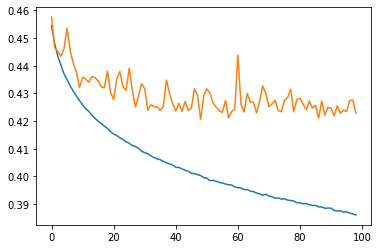

In [11]:
import matplotlib.pyplot as plt
plt.plot(loss_list[1:])
plt.plot(val_loss_list[1:])
plt.savefig('/project/hikaku_db/ziwei/Model_11/loss_plt_state_3.jpg')

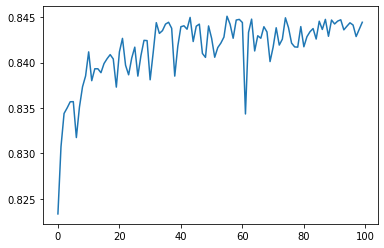

In [12]:
plt.plot(ac_list)
plt.savefig('/project/hikaku_db/ziwei/Model_11/ac_plt_state_3.jpg')

In [13]:
loss_list = pd.DataFrame([loss_list])
val_loss_list = pd.DataFrame([val_loss_list])
ac_list = pd.DataFrame([ac_list])
loss_list.to_csv('/project/hikaku_db/ziwei/Model_11/loss_list_state_3.csv',header=False,index=False)
val_loss_list.to_csv('/project/hikaku_db/ziwei/Model_11/val_loss_list_state_3.csv',header=False,index=False)
ac_list.to_csv('/project/hikaku_db/ziwei/Model_11/ac_list_state_3.csv',header=False,index=False)